In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import os, sys, datetime, glob, re
import os.path as op

import fnmatch

import logging
logger = logging.getLogger('utils') # this logger is set up and defined in utils.py

import numpy as np
np.set_printoptions(precision=4)
import pandas as pd
import matplotlib.pyplot as plt
import shutil

import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols

import scipy.stats as st

import warnings

In [4]:
sep = '\n'

#files = glob.glob("sub-*_coh_df_alllgn_allcortical*.csv")
#files = glob.glob("sub-*_coh_df_whole_revisedlgn_allcortical_conn[12].csv")
files = glob.glob("sub-*_coh_df_whole_revisedlgn_allcortical_conn[12]_volconstraint_meantarget_withphases.csv")


#files = glob.glob("sub-*_coh_df_picklgn_allcortical*.csv")

files.sort()

files_reduced = [f for f in files if 'withmanual' not in f]
#files_manual = [f for f in files if 'withmanual' in f]

files_final = files_reduced #files_manual #files_reduced

logger.debug(f"\nFound:\n{sep.join(files)}.\nWill only analyze:\n{sep.join(files_final)}")


In [5]:
!ls -ll *whole_revisedlgn*meantarget*

-rw-rw-r-- 1 smerdis smerdis   57015 Apr  8 16:48 sub-BC_coh_df_whole_revisedlgn_allcortical_conn1_volconstraint_meantarget.csv
-rw-rw-r-- 1 smerdis smerdis 1045275 Apr  8 16:48 sub-BC_coh_df_whole_revisedlgn_allcortical_conn1_volconstraint_meantarget_withphases.csv
-rw-rw-r-- 1 smerdis smerdis   56984 Apr  8 16:48 sub-BC_coh_df_whole_revisedlgn_allcortical_conn2_volconstraint_meantarget.csv
-rw-rw-r-- 1 smerdis smerdis 1045367 Apr  8 16:48 sub-BC_coh_df_whole_revisedlgn_allcortical_conn2_volconstraint_meantarget_withphases.csv
-rw-rw-r-- 1 smerdis smerdis   28462 Apr  8 16:48 sub-CF_coh_df_whole_revisedlgn_allcortical_conn1_volconstraint_meantarget.csv
-rw-rw-r-- 1 smerdis smerdis  522728 Apr  8 16:48 sub-CF_coh_df_whole_revisedlgn_allcortical_conn1_volconstraint_meantarget_withphases.csv
-rw-rw-r-- 1 smerdis smerdis   28463 Apr  8 16:48 sub-CF_coh_df_whole_revisedlgn_allcortical_conn2_volconstraint_meantarget.csv
-rw-rw-r-- 1 smerdis smerdis  522421 Apr  8 16:48 sub-CF_coh_df_whole_r

In [6]:
sub_dfs = {}
for i, file in enumerate(files_final):
    parts = file.split('_')
    if parts[0][:3] == 'sub':
        key = parts[0]
    else:
        raise Error("Coherence data files must begin with 'sub-<sub_code>'")
    df = pd.read_csv(file)
    if key in sub_dfs:
        df['session'] = 2
        concat_df = pd.concat([sub_dfs[key], df])
        sub_dfs[key] = concat_df
        assert(sub_dfs[key].session.nunique() == 2)
    else:
        df['session'] = 1
        sub_dfs[key] = df
        assert(sub_dfs[key].session.nunique() == 1)

    print(file, key, len(sub_dfs[key]))

sub-BC_coh_df_whole_revisedlgn_allcortical_conn1_volconstraint_meantarget_withphases.csv sub-BC 5016
sub-BC_coh_df_whole_revisedlgn_allcortical_conn2_volconstraint_meantarget_withphases.csv sub-BC 10032
sub-CF_coh_df_whole_revisedlgn_allcortical_conn1_volconstraint_meantarget_withphases.csv sub-CF 2508
sub-CF_coh_df_whole_revisedlgn_allcortical_conn2_volconstraint_meantarget_withphases.csv sub-CF 5016
sub-LL_coh_df_whole_revisedlgn_allcortical_conn1_volconstraint_meantarget_withphases.csv sub-LL 5016
sub-LL_coh_df_whole_revisedlgn_allcortical_conn2_volconstraint_meantarget_withphases.csv sub-LL 8360
sub-SR_coh_df_whole_revisedlgn_allcortical_conn1_volconstraint_meantarget_withphases.csv sub-SR 3876
sub-SR_coh_df_whole_revisedlgn_allcortical_conn2_volconstraint_meantarget_withphases.csv sub-SR 7752
sub-ZG_coh_df_whole_revisedlgn_allcortical_conn1_volconstraint_meantarget_withphases.csv sub-ZG 2432
sub-ZG_coh_df_whole_revisedlgn_allcortical_conn2_volconstraint_meantarget_withphases.csv s

In [7]:
df = pd.concat(sub_dfs).reset_index().drop(['level_1', 'Unnamed: 0'], axis=1).rename(columns={'level_0':'subj'})
df.head()

,subj,seed,target,measurement,freq_band,value,run,condition,bold,session
0,sub-BC,LLGNrevised,LDORSAL,coherence,NaN,0.460741,run-01,leftM,/home/smerdis/data/LGN/BIDS/BC_combined/deriva...,1
1,sub-BC,LLGNrevised,LDORSAL,phase,0.0278,-0.235500,run-01,leftM,/home/smerdis/data/LGN/BIDS/BC_combined/deriva...,1
2,sub-BC,LLGNrevised,LDORSAL,phase,0.0347,0.162300,run-01,leftM,/home/smerdis/data/LGN/BIDS/BC_combined/deriva...,1
3,sub-BC,LLGNrevised,LDORSAL,phase,0.0417,-0.032400,run-01,leftM,/home/smerdis/data/LGN/BIDS/BC_combined/deriva...,1
4,sub-BC,LLGNrevised,LDORSAL,phase,0.0486,0.436100,run-01,leftM,/home/smerdis/data/LGN/BIDS/BC_combined/deriva...,1


In [8]:
# Change V3ABC region to V3AB per MAS feedback on paper draft ~Thanksgiving 2022
df.loc[df.target=='RV3ABC', 'target'] = 'RV3AB'
df.loc[df.target=='LV3ABC', 'target'] = 'LV3AB'

# Change V4C region to V4
df.loc[df.target=='RV4C', 'target'] = 'RV4'
df.loc[df.target=='LV4C', 'target'] = 'LV4'

### Add columns that will be useful later

In [9]:
df.seed.unique()

array(['LLGNrevised', 'RLGNrevised'], dtype=object)

In [10]:
[s.split('LGN') for s in df.seed.unique()]

[['L', 'revised'], ['R', 'revised']]

In [11]:
def decide_seed_mp(row):
    # row comes in as a Series, decide if it's M or P
    slug = row['seed'].split('LGN')[-1]
    if not slug: # slug evaluates to False, aka it's empty, so name is 'LLGN' or anything with nothing after 'LGN'
        seed_mp = None
    else:
        if 'M' in slug:
            seed_mp = 'M'
        elif 'P' in slug:
            seed_mp = 'P'
        else:
            seed_mp = None
    #print(row['seed'], slug, seed_mp)
    return seed_mp

In [12]:
df['seed_hem'] = df.apply(lambda row: row['seed'][0], axis=1) # e.g. LLGNM80 => 'L'
df['seed_region'] = df.apply(lambda row: row['seed'][1:], axis=1) # e.g. LLGNM80 => LGNM80
df['target_hem'] = df.apply(lambda row: row['target'][0], axis=1) # e.g. LV1 => 'L'
df['target_region'] = df.apply(lambda row: row['target'][1:], axis=1) # e.g. LV1 => V1
#df['seed_mp'] = df.apply(lambda row: row['seed'].split('LGN')[-1][0] if row['seed'].split('LGN')[-1] else None, axis=1) # e.g. LLGNM80 => 'M', assumes seed contains 'LGN'
df['seed_mp'] = df.apply(decide_seed_mp, axis=1) # e.g. LLGNM80 => 'M', assumes seed contains 'LGN'
df['stim_type'] = df.apply(lambda row: row['condition'][-1], axis=1) # e.g. 'leftM' => 'M'
df['attend_hem'] = df.apply(lambda row: row['condition'][0].upper(), axis=1) # e.g. 'leftM' => 'L'


In [13]:
# Check that there are only as many unique values as we expect (L/R, M/P)
#assert(df['seed_hem'].nunique() == 2)
assert(df['target_hem'].nunique() == 2)
# assert(df['seed_mp'].nunique() == 2) # but there may be Nones, e.g. for LLGN as a whole (not M/P)
assert(df['stim_type'].nunique() == 2)
assert(df['attend_hem'].nunique() == 2)

In [14]:
df.seed_mp.unique()

array([None], dtype=object)

In [15]:
df.seed_region.unique()

array(['LGNrevised'], dtype=object)

In [16]:
# Are the seed and target in same hemisphere?
df['ipsi_seedtarget'] = df.apply(lambda row: row['seed_hem'] == row['target_hem'], axis=1)
df['ipsi_seedtarget'].value_counts()

True    37240
Name: ipsi_seedtarget, dtype: int64

In [17]:
# Is the stimulation type the same as the seed region for this row?
df['seed_stim'] = df.apply(lambda row: row['seed_mp'] == row['stim_type'], axis=1)
df['seed_stim'].value_counts()

False    37240
Name: seed_stim, dtype: int64

### Identify grouping variables

In [18]:
constructed_cols = ['seed_hem','seed_region','target_hem','target_region','seed_mp','stim_type',
                    'attend_hem','ipsi_seedtarget','seed_stim']
id_cols = ['subj','seed','target','measurement','condition']
gvars_sub = [*id_cols, *constructed_cols]

In [19]:
df['target_region'].unique()

array(['DORSAL', 'IPS', 'LO', 'TO', 'v1', 'V2', 'V3', 'V3AB', 'V4',
       'VENTRAL', 'VO'], dtype=object)

### Group target ROIs

In [20]:
df.groupby('subj')['target_region'].unique()

subj
sub-BC    [DORSAL, IPS, LO, TO, v1, V2, V3, V3AB, V4, VE...
sub-CF                      [DORSAL, IPS, v1, V2, V3, V3AB]
sub-LL    [DORSAL, IPS, LO, TO, v1, V2, V3, V3AB, V4, VE...
sub-SR     [DORSAL, IPS, LO, TO, v1, V2, V3, V3AB, VENTRAL]
sub-ZG         [DORSAL, IPS, LO, v1, V2, V3, V3AB, VENTRAL]
Name: target_region, dtype: object

In [21]:
targets = df.target.unique()
# early_vis_rois = [f for f in targets if fnmatch.fnmatch(f, '*[LR]v[12]*')]
# v3s = [f for f in targets if fnmatch.fnmatch(f, '*[LR]v3[dab]*')]
# v3vs = [f for f in targets if fnmatch.fnmatch(f, '*[LR]v3v*')]
# ips = [f for f in targets if fnmatch.fnmatch(f, '*[LR]ips*')]
# dorsal = v3s + ips
# v4s = [f for f in targets if fnmatch.fnmatch(f, '*[LR]v4*')]
# ventral = v3vs + v4s + [f for f in targets if fnmatch.fnmatch(f, '*[LR][vtl]o*')]
print(targets, len(targets)) #, early_vis_rois, len(early_vis_rois), 
      #dorsal, len(dorsal), ventral, len(ventral), sep="\n")



['LDORSAL' 'LIPS' 'LLO' 'LTO' 'Lv1' 'LV2' 'LV3' 'LV3AB' 'LV4' 'LVENTRAL'
 'LVO' 'RDORSAL' 'RIPS' 'RLO' 'RTO' 'Rv1' 'RV2' 'RV3' 'RV3AB' 'RV4'
 'RVENTRAL' 'RVO'] 22


In [22]:
target_regions = df.target_region.unique()
print(target_regions, len(target_regions))
# define the target regions we wish to plot and the order they are to be plotted in
target_regions_ordered = ['v1', 'V2', 'V3', 'V3AB', 'IPS', 'TO', 'V4', 'VO', 'LO', 'DORSAL', 'VENTRAL',                      
'v2d', 'v2v', 'v3d', 'v3v', 'v4',
 'ips0', 'ips1', 'ips2', 'ips3', 'ips4', 'ips5',
'lo1', 'lo2', 'to1', 'to2',  'vo1', 'vo2']
print(target_regions_ordered, len(target_regions_ordered))
df['target_region'] = pd.Categorical(df.target_region, categories=target_regions_ordered, ordered=True)

['DORSAL' 'IPS' 'LO' 'TO' 'v1' 'V2' 'V3' 'V3AB' 'V4' 'VENTRAL' 'VO'] 11
['v1', 'V2', 'V3', 'V3AB', 'IPS', 'TO', 'V4', 'VO', 'LO', 'DORSAL', 'VENTRAL', 'v2d', 'v2v', 'v3d', 'v3v', 'v4', 'ips0', 'ips1', 'ips2', 'ips3', 'ips4', 'ips5', 'lo1', 'lo2', 'to1', 'to2', 'vo1', 'vo2'] 28


In [23]:
display_regions = ['v1', 'V2', 'V3', 'V3AB', 'IPS', 'LO', 'V4', 'TO', 'VO', 'DORSAL', 'VENTRAL']

In [24]:
df = df.sort_values(by=['subj', 'seed', 'target_region', 'target'])
df[df.subj=='sub-LL']

,subj,seed,target,measurement,freq_band,value,run,condition,bold,session,seed_hem,seed_region,target_hem,target_region,seed_mp,stim_type,attend_hem,ipsi_seedtarget,seed_stim
15960,sub-LL,LLGNrevised,Lv1,coherence,NaN,0.553401,run-01,leftM,/home/smerdis/data/LGN/BIDS/LL_combined/deriva...,1,L,LGNrevised,L,v1,None,M,L,True,False
15961,sub-LL,LLGNrevised,Lv1,phase,0.0278,-0.421000,run-01,leftM,/home/smerdis/data/LGN/BIDS/LL_combined/deriva...,1,L,LGNrevised,L,v1,None,M,L,True,False
15962,sub-LL,LLGNrevised,Lv1,phase,0.0347,-0.769900,run-01,leftM,/home/smerdis/data/LGN/BIDS/LL_combined/deriva...,1,L,LGNrevised,L,v1,None,M,L,True,False
15963,sub-LL,LLGNrevised,Lv1,phase,0.0417,-0.455900,run-01,leftM,/home/smerdis/data/LGN/BIDS/LL_combined/deriva...,1,L,LGNrevised,L,v1,None,M,L,True,False
15964,sub-LL,LLGNrevised,Lv1,phase,0.0486,-0.084500,run-01,leftM,/home/smerdis/data/LGN/BIDS/LL_combined/deriva...,1,L,LGNrevised,L,v1,None,M,L,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23251,sub-LL,RLGNrevised,RVENTRAL,phase,0.1181,-2.160400,run-08,rightP,/home/smerdis/data/LGN/BIDS/LL_combined/deriva...,2,R,LGNrevised,R,VENTRAL,None,P,R,True,False
23252,sub-LL,RLGNrevised,RVENTRAL,phase,0.1250,-2.760800,run-08,rightP,/home/smerdis/data/LGN/BIDS/LL_combined/deriva...,2,R,LGNrevised,R,VENTRAL,None,P,R,True,False
23253,sub-LL,RLGNrevised,RVENTRAL,phase,0.1319,-2.745400,run-08,rightP,/home/smerdis/data/LGN/BIDS/LL_combined/deriva...,2,R,LGNrevised,R,VENTRAL,None,P,R,True,False
23254,sub-LL,RLGNrevised,RVENTRAL,phase,0.1389,-1.584200,run-08,rightP,/home/smerdis/data/LGN/BIDS/LL_combined/deriva...,2,R,LGNrevised,R,VENTRAL,None,P,R,True,False


In [25]:
df_phase = df[df['measurement']=='phase'].copy()
df = df[(df['measurement']=='coherence') & (df['freq_band'].isna())].copy()
df = df.sort_values(by=['subj', 'seed', 'target_region', 'target'])
# df should now be identical to what it contained before phase info was output (march 2023)

In [26]:
df_ipsi = df[df['ipsi_seedtarget']] # only ipsilateral seed-target pairs
print(len(df_ipsi))
df_biglgn = df[df['seed_mp'].isna()] # only whole LGN seed regions, not M/P subregions
print(len(df_biglgn))
df_ipsi_biglgn = df_ipsi[df_ipsi['seed_mp'].isna()] # only whole-lgn seeds with ipsilateral cortical targets
print(df_ipsi_biglgn['seed'].unique())
df_ipsi_sublgn = df_ipsi[~df_ipsi['seed_mp'].isna()] # only sub-lgn (M/P) seeds with ipsilateral cortical targets
print(df_ipsi_sublgn['seed_region'].unique())
print(len(df_ipsi_sublgn))

1960
1960
['LLGNrevised' 'RLGNrevised']
[]
0


## Analysis via collapsing across various things

### Graphs

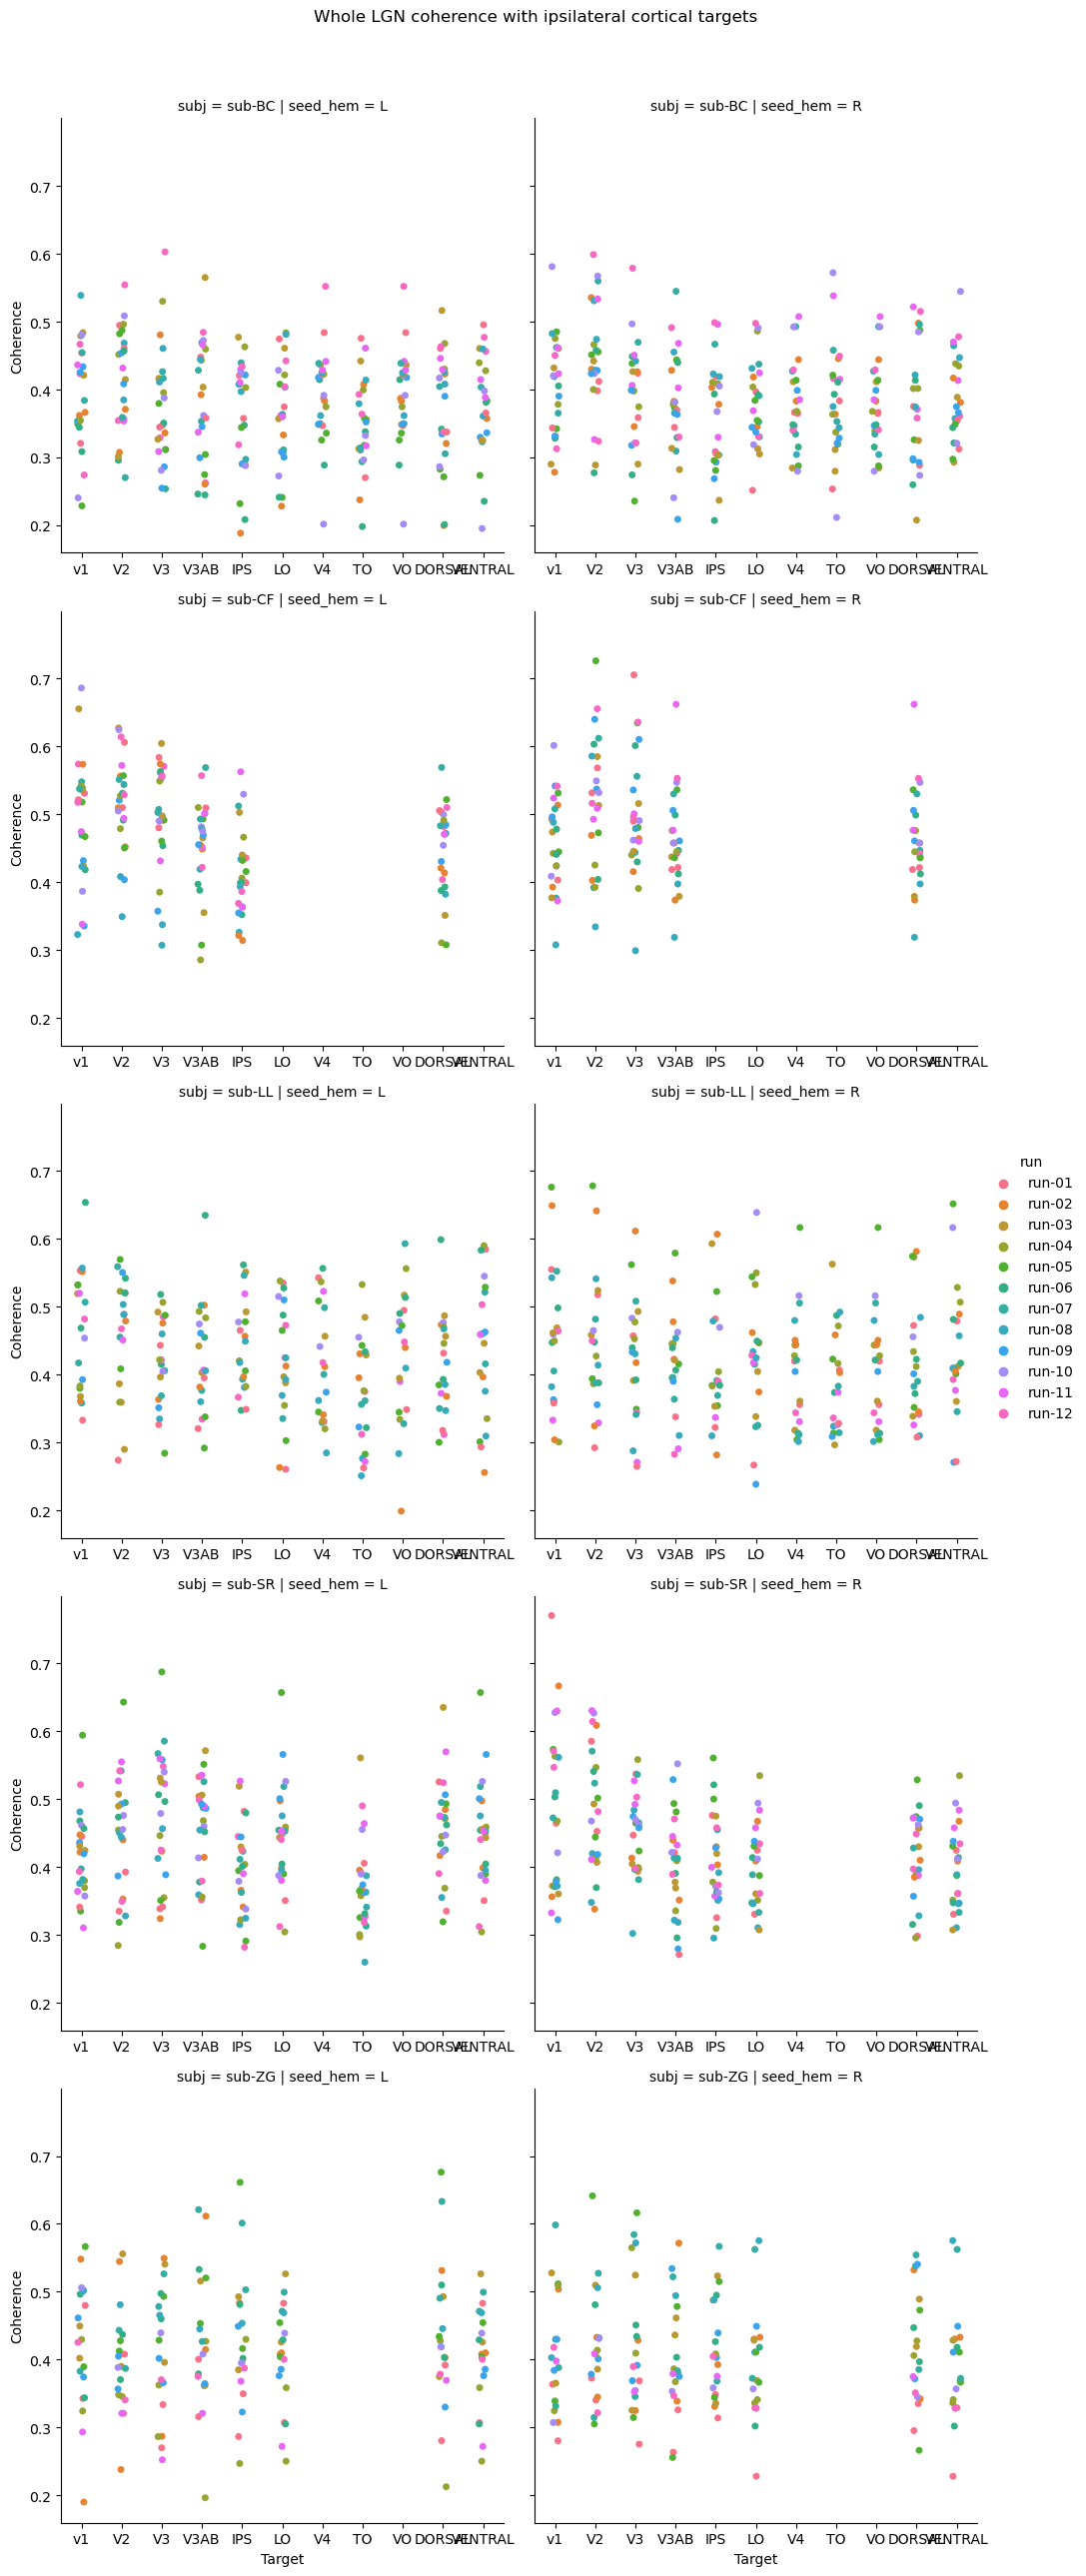

In [27]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sns.catplot(data=df_ipsi_biglgn, kind='strip', x='target_region', y='value', row='subj', hue='run', col='seed_hem',
            sharex=False, legend=True, order=display_regions).set_axis_labels('Target', "Coherence") \
            .fig.suptitle("Whole LGN coherence with ipsilateral cortical targets", y=1.03)

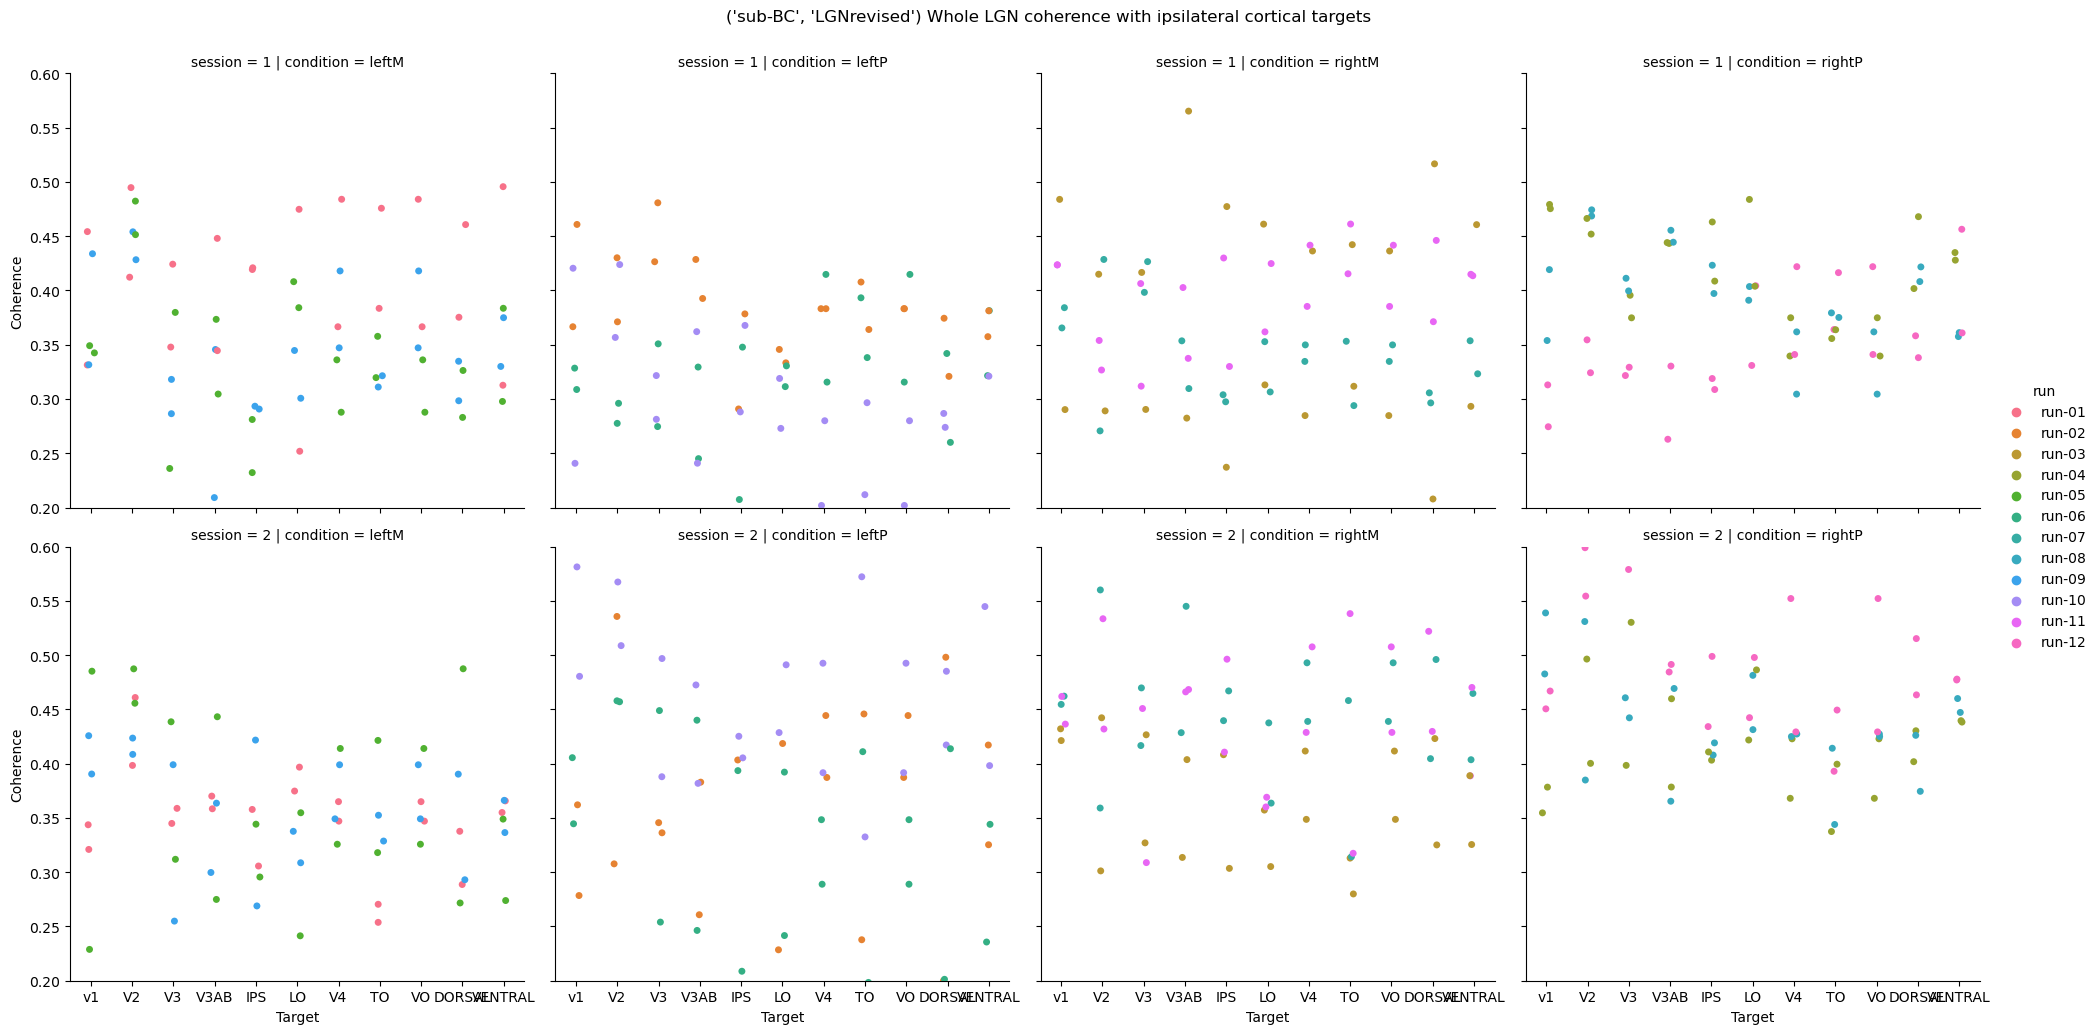

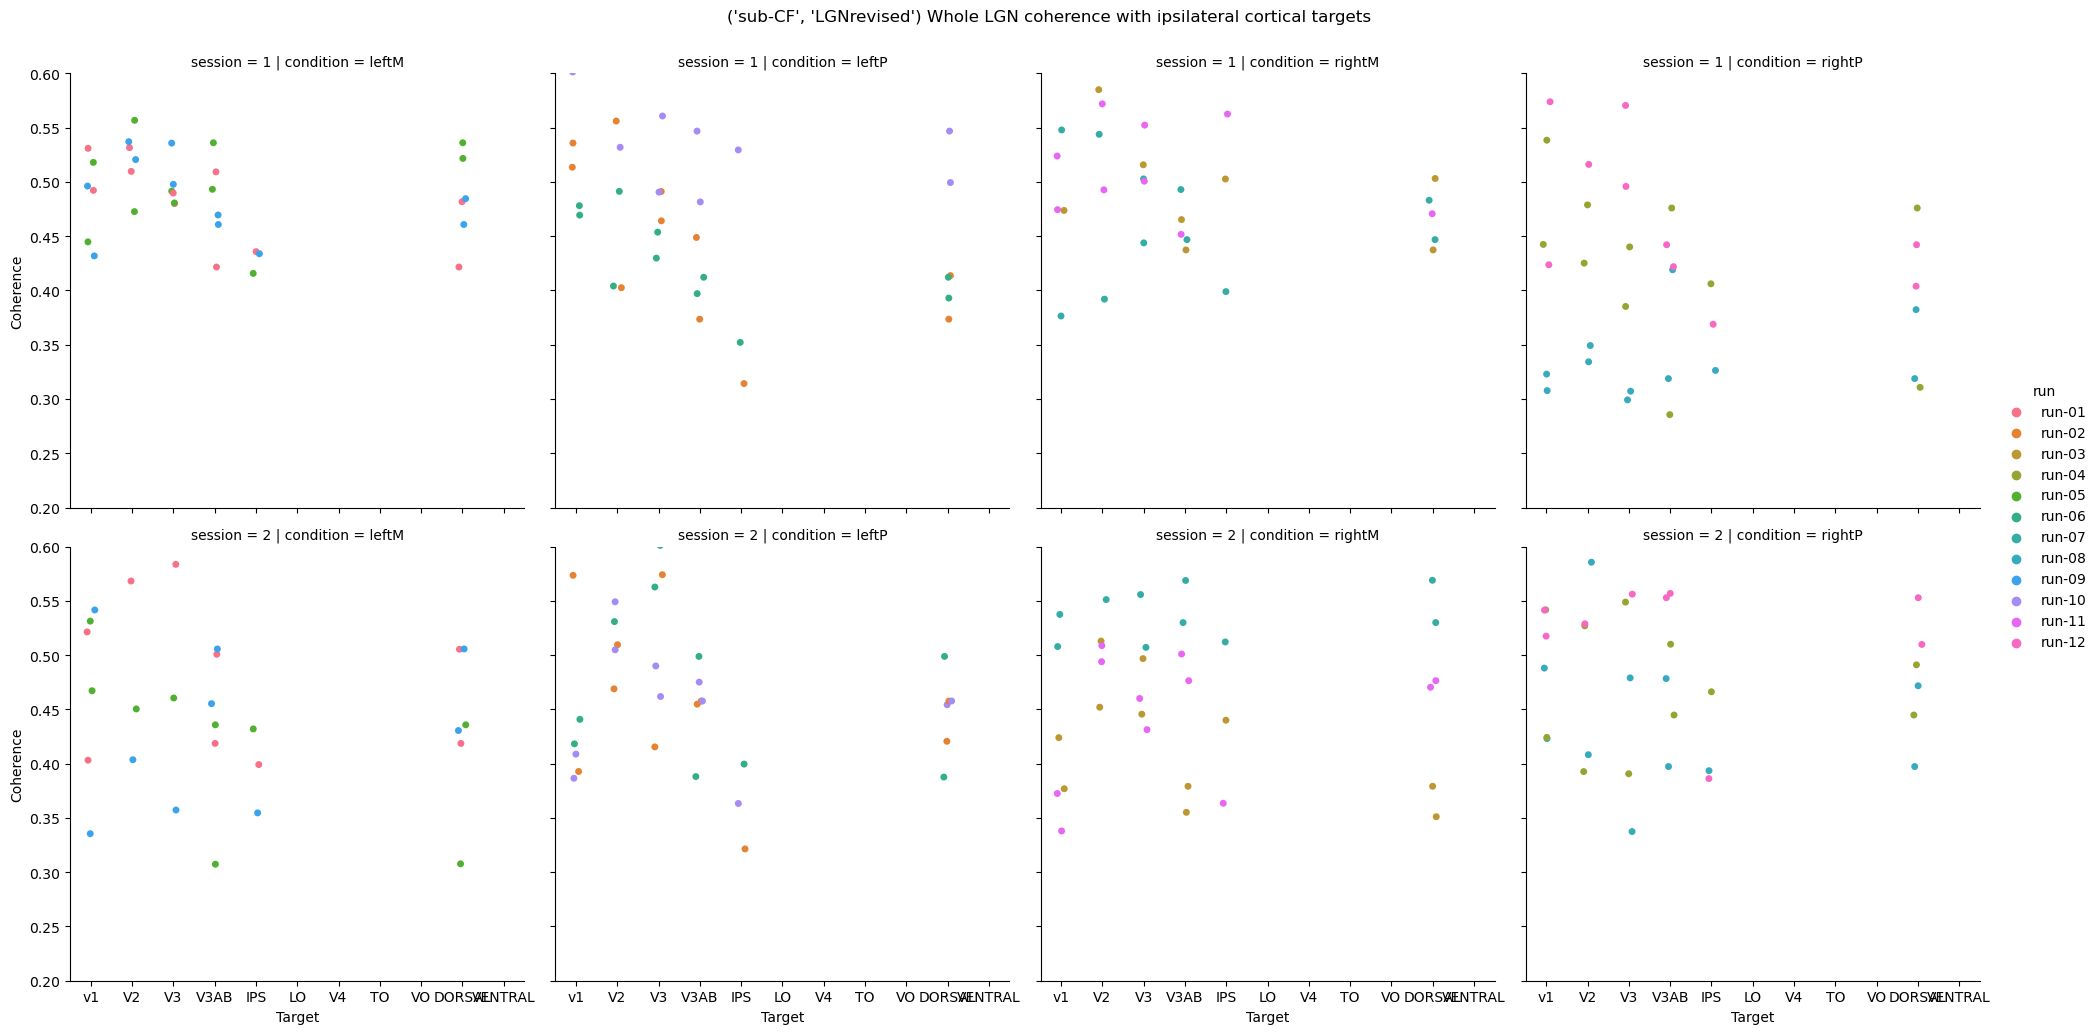

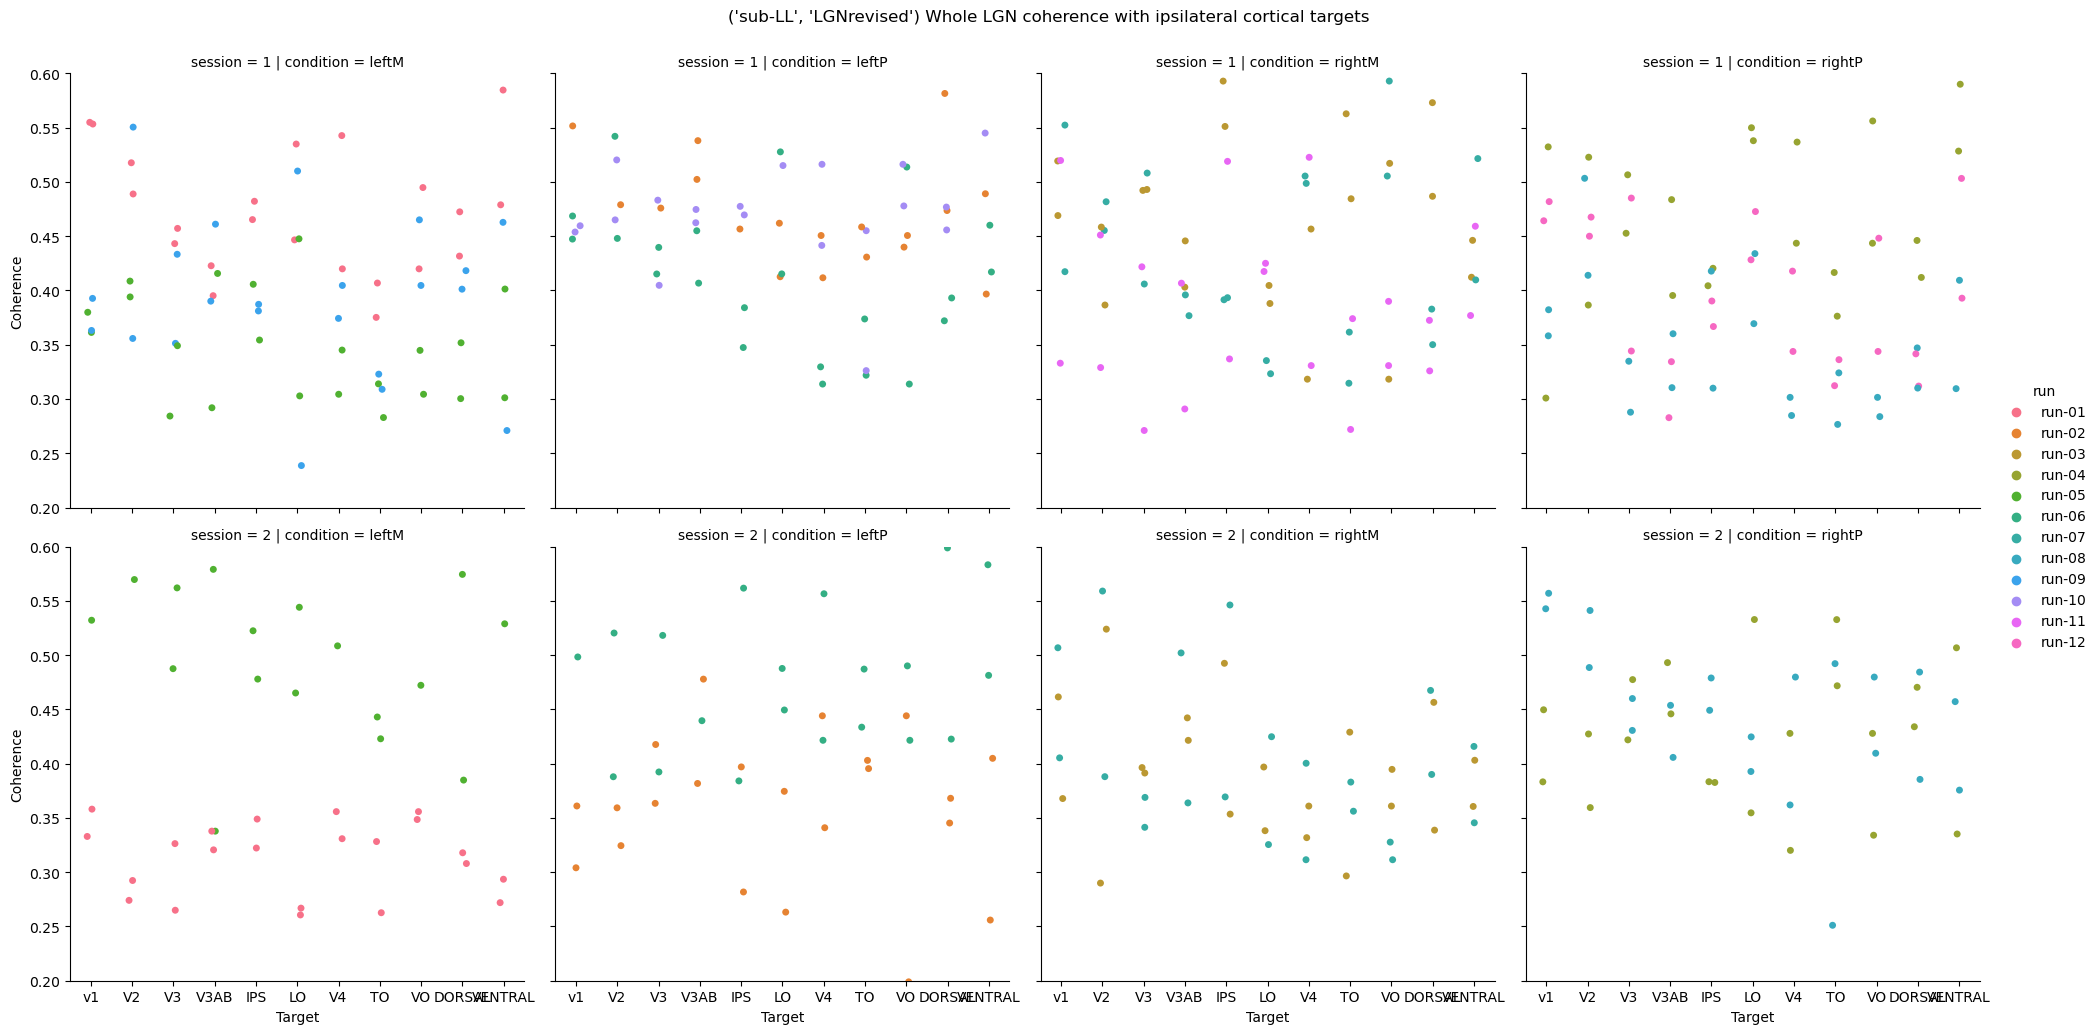

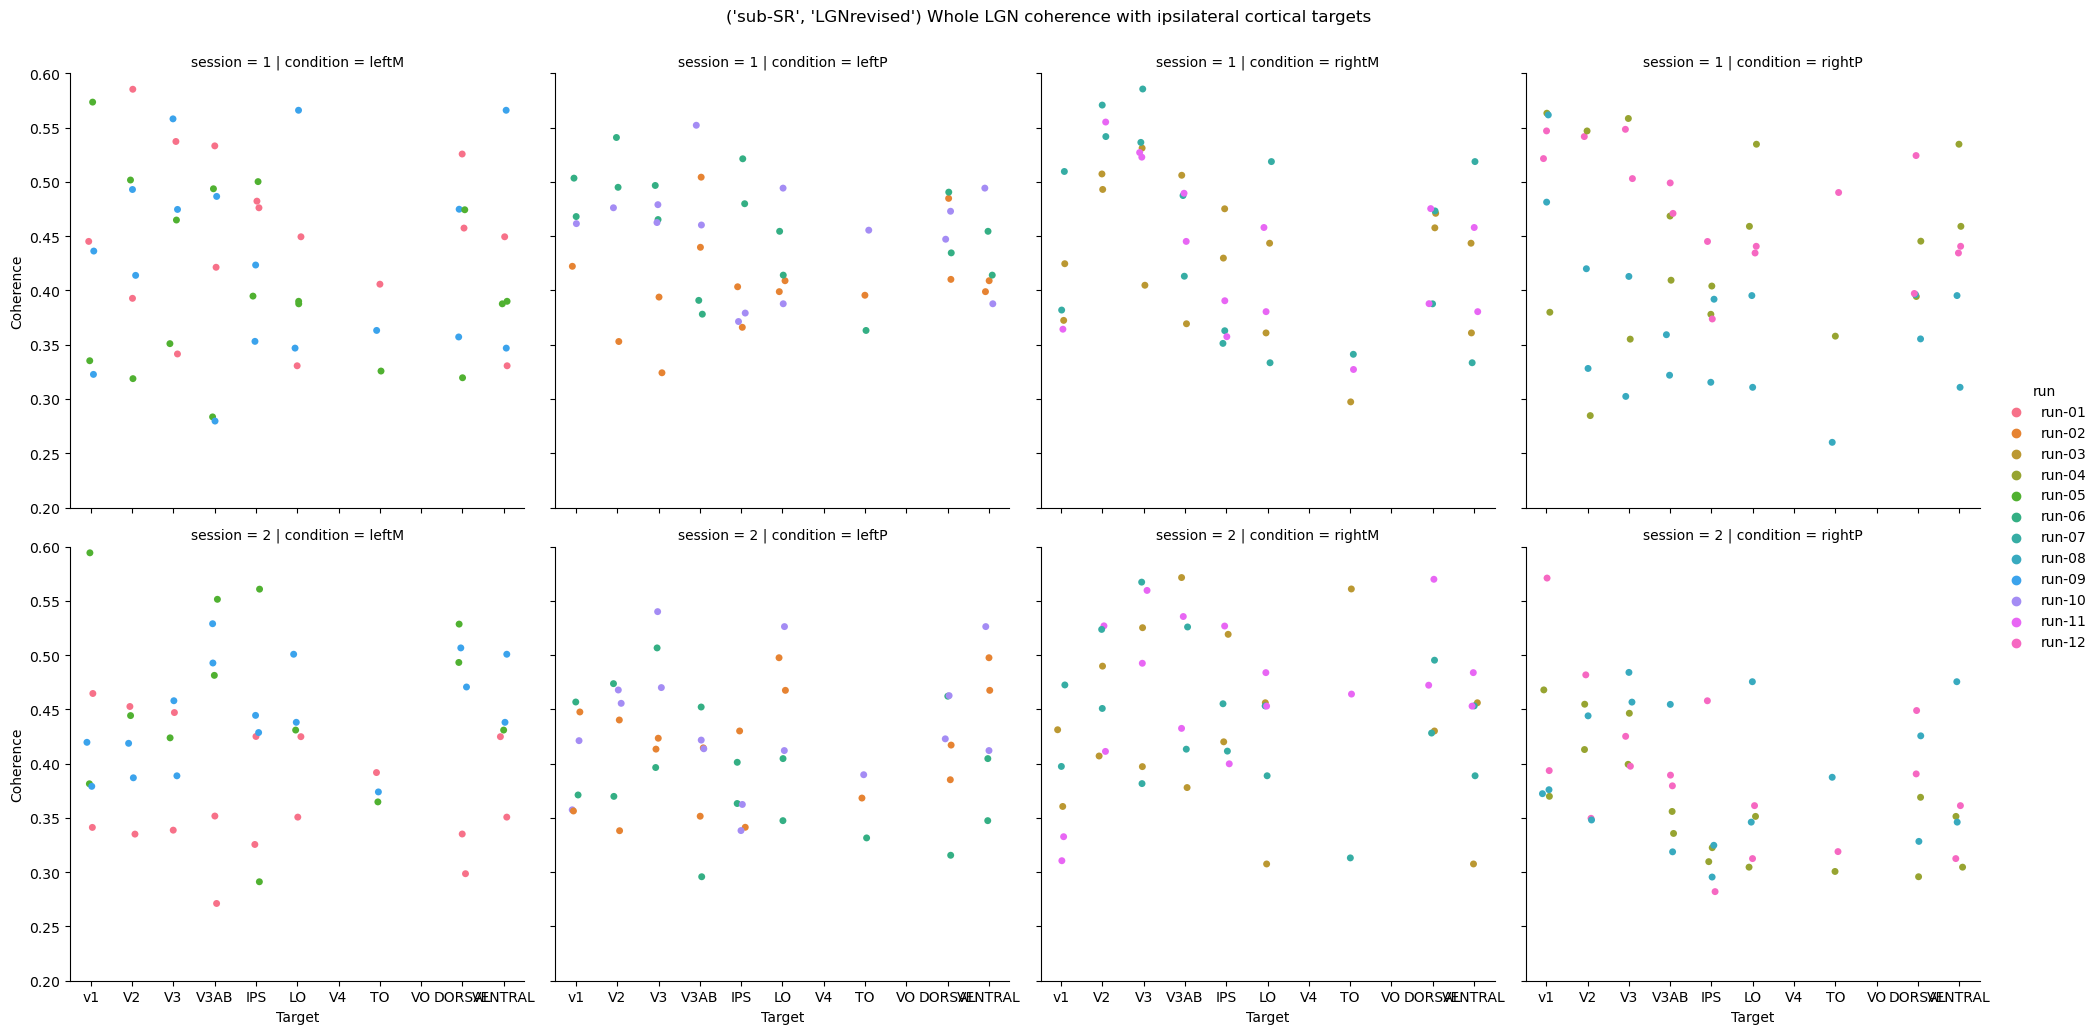

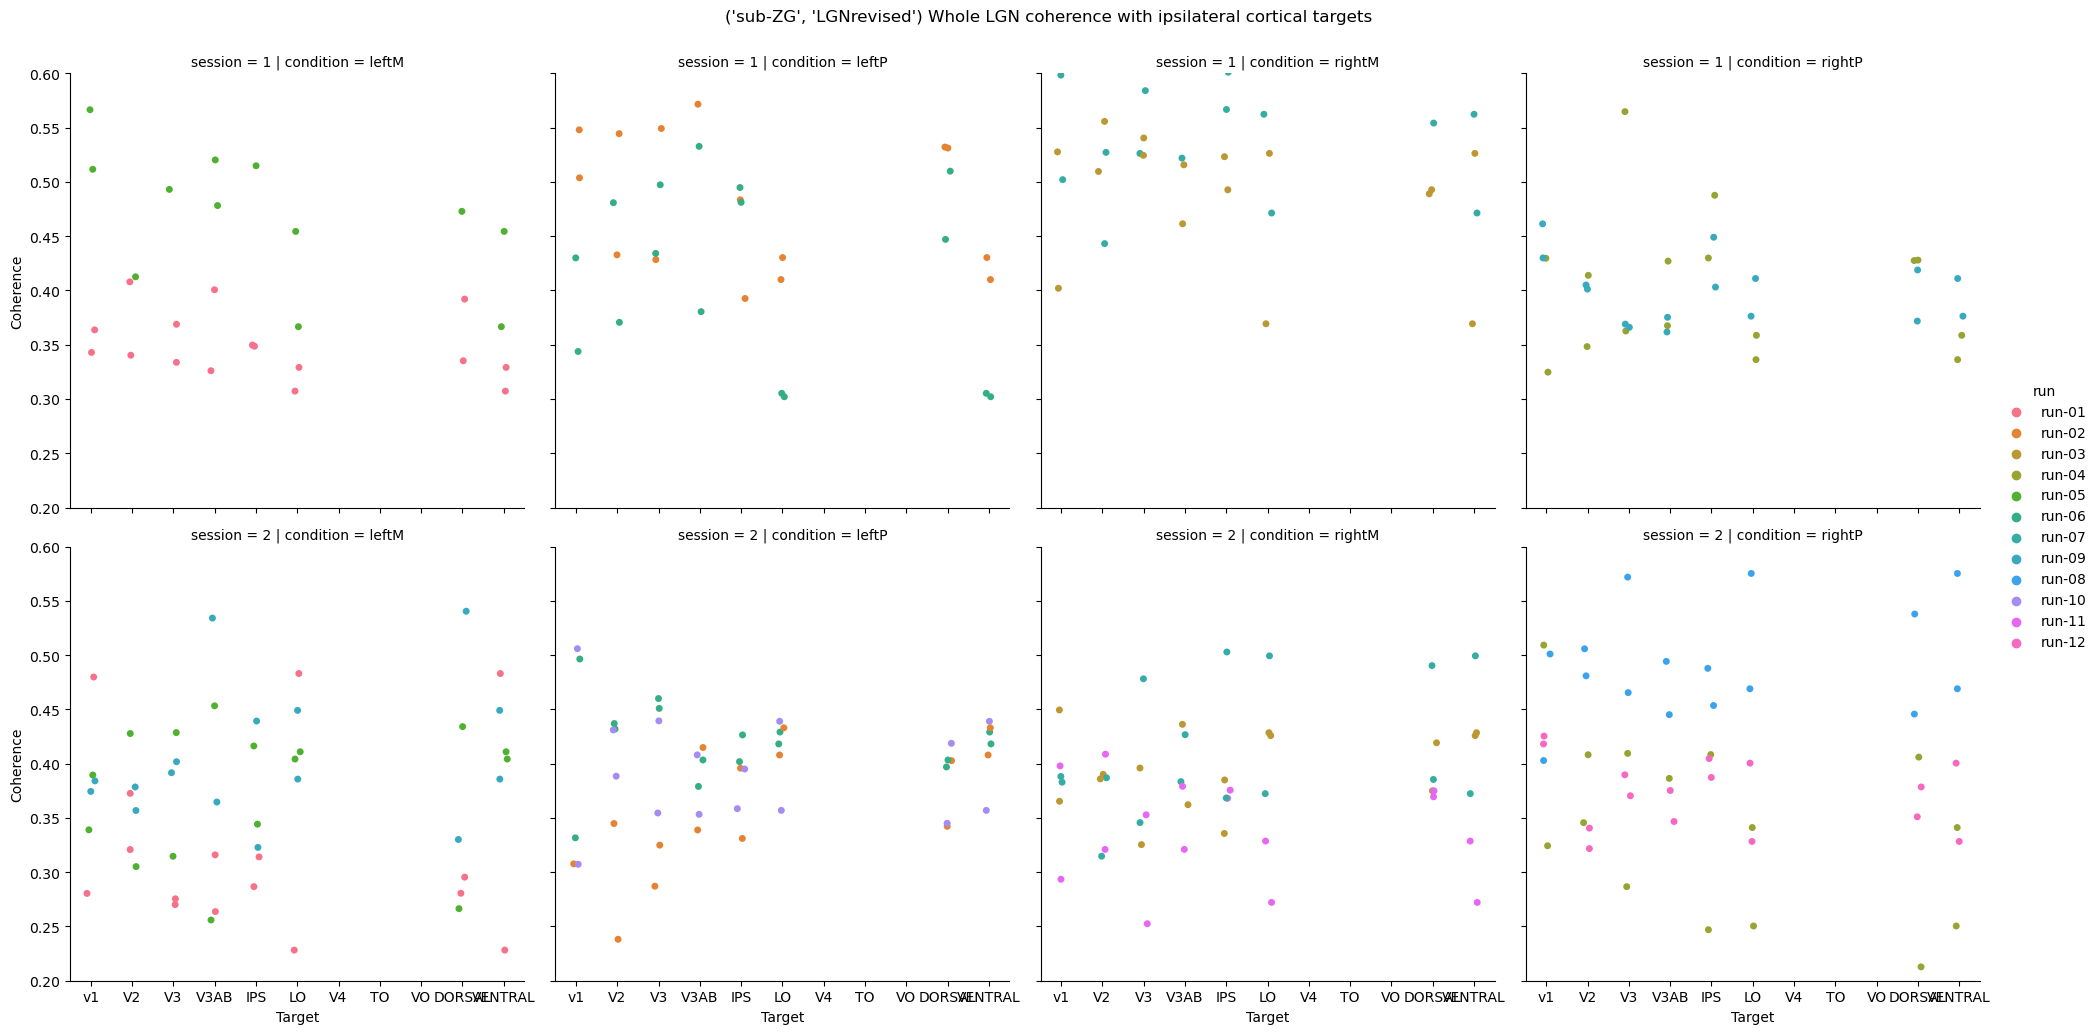

In [28]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ylim= (0.2, 0.6)
    for gv, g in df_ipsi_biglgn.groupby(['subj', 'seed_region']):
        sns.catplot(data=g.reset_index(), kind='strip', x='target_region', y='value', row='session',
                    col='condition', hue='run', legend=True, order=display_regions) \
        .set(ylim=ylim)\
        .set_axis_labels('Target', "Coherence") \
        .fig.suptitle(f"{gv} Whole LGN coherence with ipsilateral cortical targets", y=1.03)

In [29]:
gvars_sub_ses = gvars_sub + ['session']
print(gvars_sub_ses)

['subj', 'seed', 'target', 'measurement', 'condition', 'seed_hem', 'seed_region', 'target_hem', 'target_region', 'seed_mp', 'stim_type', 'attend_hem', 'ipsi_seedtarget', 'seed_stim', 'session']


In [30]:
mean_groups = df_ipsi_sublgn.groupby(gvars_sub_ses, observed=True)
print(len(mean_groups))
#for gv, g in mean_groups:
#    print(gv, len(g), np.mean(g['value']), sep='\n')

0


In [31]:
df_meanrun = mean_groups['value'].agg(['mean','sem'])
# next line renames the columns returned by agg() only since we haven't reset the index yet
df_meanrun.columns = df_meanrun.columns.map(lambda x: f"value_{x}")
df_meanrun = df_meanrun.reset_index()
df_meanrun.head()

,subj,seed,target,measurement,condition,seed_hem,seed_region,target_hem,target_region,seed_mp,stim_type,attend_hem,ipsi_seedtarget,seed_stim,session,value_mean,value_sem


In [32]:
display_order = [v for v in df_meanrun.target_region.cat.categories if v in display_regions]

In [33]:
gvars_sub_ses_xatt = list(set(gvars_sub_ses).difference(['condition','attend_hem']))
gvars_sub_xatt_xses = list(set(gvars_sub_ses_xatt).difference(['session']))

df_meanrun_xatt_groups = df_meanrun.groupby(gvars_sub_ses_xatt, observed=True)
for gv, g in df_meanrun_xatt_groups:
    print(gv, len(g))

df_meanrun_xatt = df_meanrun_xatt_groups['value_mean'].agg(['mean', 'sem']).reset_index()


In [34]:
df_meanrun_xatt_xses_groups = df_meanrun_xatt.groupby(gvars_sub_xatt_xses, observed=True)
for gv, g in df_meanrun_xatt_xses_groups:
    print(gv, len(g))

df_meanrun_xatt_xses = df_meanrun_xatt_xses_groups['mean'].agg(['mean', 'sem']).reset_index()


## Attention contrasts

In [35]:
#att_contrast_cols = ['subj', 'seed', 'target', 'measurement', 'seed_hem', 'seed_region', 
#                    'target_hem','target_region','seed_mp', 'stim_type', 'ipsi_seedtarget']
att_contrast_cols = ['subj', 'seed', 'target', 'measurement', 'seed_hem', 'seed_region', 
                    'target_hem','target_region','stim_type', 'ipsi_seedtarget']
att_xmp_cols = list(set(att_contrast_cols).difference(['stim_type']))
att_xmpseed_cols = list(set(att_xmp_cols).difference(['seed', 'seed_mp', 'seed_region']))
att_xmpseedhem_cols = list(set(att_xmpseed_cols).difference(['seed_hem','target_hem','target']))

In [36]:
gvars_sub_ses_biglgn = list(set(gvars_sub_ses).difference(['seed_mp'])) # seed_mp is None for big LGNs
gvars_sub_biglgn = list(set(gvars_sub_ses_biglgn).difference(['session']))

In [37]:
df_meanrun_biglgn = df_ipsi_biglgn.groupby(gvars_sub_ses_biglgn, observed=True)['value'].agg(['mean','sem'])
# next line renames the columns returned by agg() only since we haven't reset the index yet
df_meanrun_biglgn.columns = df_meanrun_biglgn.columns.map(lambda x: f"value_{x}")
df_meanrun_biglgn = df_meanrun_biglgn.reset_index()
df_meanrun_biglgn.head(n=20)

,seed_stim,condition,attend_hem,measurement,seed_region,seed_hem,target_hem,stim_type,subj,session,ipsi_seedtarget,target,target_region,seed,value_mean,value_sem
0,False,leftM,L,coherence,LGNrevised,L,L,M,sub-BC,1,True,LDORSAL,DORSAL,LLGNrevised,0.359519,0.052770
1,False,leftM,L,coherence,LGNrevised,L,L,M,sub-BC,1,True,LIPS,IPS,LLGNrevised,0.314603,0.055787
2,False,leftM,L,coherence,LGNrevised,L,L,M,sub-BC,1,True,LLO,LO,LLGNrevised,0.394544,0.050725
3,False,leftM,L,coherence,LGNrevised,L,L,M,sub-BC,1,True,LTO,TO,LLGNrevised,0.381527,0.049024
4,False,leftM,L,coherence,LGNrevised,L,L,M,sub-BC,1,True,LV2,V2,LLGNrevised,0.477088,0.012054
5,False,leftM,L,coherence,LGNrevised,L,L,M,sub-BC,1,True,LV3,V3,LLGNrevised,0.338037,0.027387
6,False,leftM,L,coherence,LGNrevised,L,L,M,sub-BC,1,True,LV3AB,V3AB,LLGNrevised,0.366072,0.042660
7,False,leftM,L,coherence,LGNrevised,L,L,M,sub-BC,1,True,LV4,V4,LLGNrevised,0.412722,0.042805
8,False,leftM,L,coherence,LGNrevised,L,L,M,sub-BC,1,True,LVENTRAL,VENTRAL,LLGNrevised,0.403098,0.048807
9,False,leftM,L,coherence,LGNrevised,L,L,M,sub-BC,1,True,LVO,VO,LLGNrevised,0.412722,0.042805


In [38]:
df_meanrun_biglgn.groupby(att_contrast_cols + ['attend_hem','seed_hem', 'session'], observed=True)['value_mean'].describe()

count  \
subj   seed        target  measurement seed_hem seed_region target_hem target_region stim_type ipsi_seedtarget attend_hem seed_hem session          
sub-BC LLGNrevised LDORSAL coherence   L        LGNrevised  L          DORSAL        M         True            L          L        1          1.0   
                                                                                                                                   2          1.0   
                                                                                                               R          L        1          1.0   
                                                                                                                                   2          1.0   
                                                                                     P         True            L          L        1          1.0   
...                                                                                                                                           ...   
sub-ZG RLGNrevised Rv1     coherence   R        LGNrevised  R          v1            M         True            R          R        2          1.0   
                                                                                     P         True            L          R        1          1.0   
                                                                                                                                   2          1.0   
                                                                                                               R          R        1          1.0   
                                                                                                                                   2          1.0   

                                                                                                                                                mean  \
subj   seed        target  measurement seed_hem seed_region target_hem target_region stim_type ipsi_seedtarget attend_hem seed_hem session             
sub-BC LLGNrevised LDORSAL coherence   L        LGNrevised  L          DORSAL        M         True            L          L        1        0.359519   
                                                                                                                                   2        0.333256   
                                                                                                               R          L        1        0.422849   
                                                                                                                                   2        0.419197   
                                                                                     P         True            L          L        1        0.316489   
...                                                                                                                                              ...   
sub-ZG RLGNrevised Rv1     coherence   R        LGNrevised  R          v1            M         True            R          R        2        0.383879   
                                                                                     P         True            L          R        1        0.466926   
                                                                                                                                   2        0.315567   
                                                                                                               R          R        1        0.377387   
                                                                                                                                   2        0.443476   

                                                                                                                                            std  \
subj   seed        target  measurement seed_hem seed_region target_hem target_

In [39]:
model = ols("value_mean ~ C(target_region)", df_meanrun_biglgn, missing='drop').fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table[['F', 'PR(>F)']]

/home/smerdis/anaconda3/envs/sns12/lib/python3.10/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 27, but rank is 10
  warnings.warn('covariance of constraints does not have full '


,F,PR(>F)
C(target_region),9.874981,1.458756e-15
Residual,NaN,NaN


In [40]:
def att_lr_diff(df):
    assert(len(df)==2)
    l = df[df.attend_hem=='L']['value_mean']
    assert(len(l)==1)
    r = df[df.attend_hem=='R']['value_mean']
    assert(len(r)==1)
    diff = l.iloc[0] - r.iloc[0]
    #print(diff)
    return pd.Series({'att_lr_diff': diff})

In [41]:
att_lr_diffs = df_meanrun_biglgn.groupby(att_contrast_cols + ['session'], observed=True).apply(att_lr_diff).reset_index()
att_lr_diffs

,subj,seed,target,measurement,seed_hem,seed_region,target_hem,target_region,stim_type,ipsi_seedtarget,session,att_lr_diff
0,sub-BC,LLGNrevised,LDORSAL,coherence,L,LGNrevised,L,DORSAL,M,True,1,-0.063329
1,sub-BC,LLGNrevised,LDORSAL,coherence,L,LGNrevised,L,DORSAL,M,True,2,-0.085941
2,sub-BC,LLGNrevised,LDORSAL,coherence,L,LGNrevised,L,DORSAL,P,True,1,-0.088288
3,sub-BC,LLGNrevised,LDORSAL,coherence,L,LGNrevised,L,DORSAL,P,True,2,-0.167143
4,sub-BC,LLGNrevised,LIPS,coherence,L,LGNrevised,L,IPS,M,True,1,-0.086968
...,...,...,...,...,...,...,...,...,...,...,...,...
347,sub-ZG,RLGNrevised,RVENTRAL,coherence,R,LGNrevised,R,VENTRAL,P,True,2,-0.012184
348,sub-ZG,RLGNrevised,Rv1,coherence,R,LGNrevised,R,v1,M,True,1,-0.125423
349,sub-ZG,RLGNrevised,Rv1,coherence,R,LGNrevised,R,v1,M,True,2,-0.049307
350,sub-ZG,RLGNrevised,Rv1,coherence,R,LGNrevised,R,v1,P,True,1,0.089539


In [42]:
# plot_df = att_lr_diffs
# plot_df['target_region_str'] = plot_df.target_region.astype(str)
# g = sns.catplot(data=plot_df, kind='box', x='target_region', y='att_lr_diff', row='subj', col='stim_type',
#                 hue='target_hem', sharex=False, legend=True, ci=None, order=display_order)
# g.map_dataframe(sns.swarmplot, x='target_region', y='att_lr_diff', hue='target_hem', s=3,
#                 palette=['#444444'], dodge=True, order=display_order)
# g.set_axis_labels('Target', "Attend L - Attend R Coherence difference") \
#         .fig.suptitle("Spatial attention difference in LGN subregion coherence with ipsilateral cortical targets", y=1.03)

In [43]:
att_df = att_lr_diffs.groupby(att_contrast_cols, observed=True)['att_lr_diff'].agg(['mean', 'sem'])
att_df.columns = att_df.columns.map(lambda x: f"attlr_{x}")
att_df = att_df.reset_index()
att_df_reduced = att_df[att_df.target_region.isin(display_regions)].copy()
att_df_reduced.head()


,subj,seed,target,measurement,seed_hem,seed_region,target_hem,target_region,stim_type,ipsi_seedtarget,attlr_mean,attlr_sem
0,sub-BC,LLGNrevised,LDORSAL,coherence,L,LGNrevised,L,DORSAL,M,True,-0.074635,0.011306
1,sub-BC,LLGNrevised,LDORSAL,coherence,L,LGNrevised,L,DORSAL,P,True,-0.127716,0.039428
2,sub-BC,LLGNrevised,LIPS,coherence,L,LGNrevised,L,IPS,M,True,-0.065944,0.021024
3,sub-BC,LLGNrevised,LIPS,coherence,L,LGNrevised,L,IPS,P,True,-0.112532,0.028344
4,sub-BC,LLGNrevised,LLO,coherence,L,LGNrevised,L,LO,M,True,-0.017021,0.035052


In [44]:
att_df_xmp = att_df_reduced.groupby(att_xmp_cols, observed=True)['attlr_mean'].mean().reset_index()
att_df_xmp_xseed = att_df_xmp.groupby(att_xmpseed_cols, observed=True)['attlr_mean'].mean().reset_index()
print(len(att_df_reduced), len(att_df_xmp), len(att_df_xmp_xseed))

176 88 88


In [45]:
att_df_xmp_xseed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   measurement      88 non-null     object  
 1   seed_hem         88 non-null     object  
 2   target_hem       88 non-null     object  
 3   subj             88 non-null     object  
 4   ipsi_seedtarget  88 non-null     bool    
 5   target           88 non-null     object  
 6   target_region    88 non-null     category
 7   attlr_mean       88 non-null     float64 
dtypes: bool(1), category(1), float64(1), object(5)
memory usage: 5.7+ KB


Text(0.5, 1.03, 'Spatial attention difference in LGN subregion coherence with ipsilateral cortical targets')

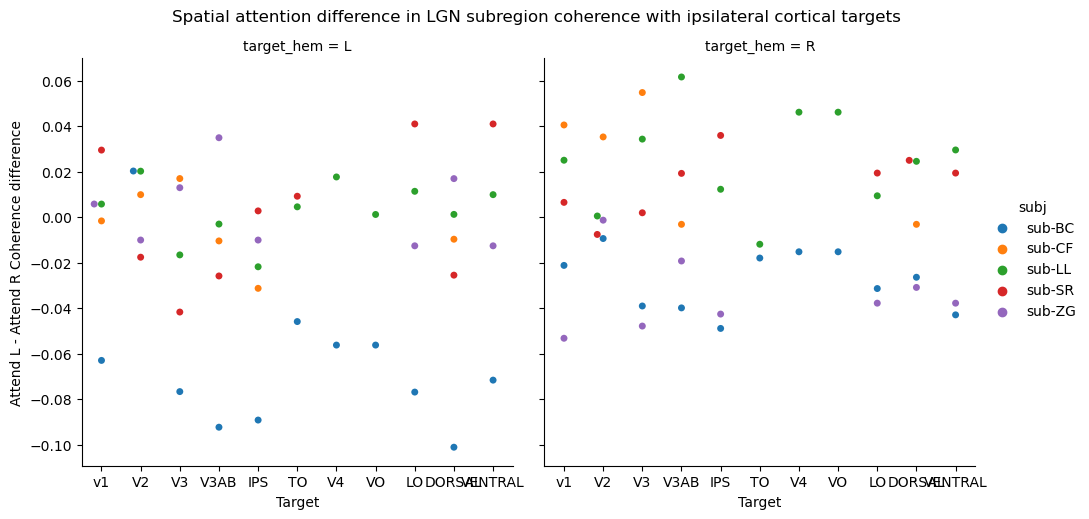

In [46]:
plot_df = att_df_xmp_xseed
plot_df['target_region_str'] = plot_df.target_region.astype(str)
g = sns.catplot(data=plot_df, kind='swarm', x='target_region', y='attlr_mean', col='target_hem', hue='subj',
                sharex=False, legend=True, ci=None, order=display_order)
g.set_axis_labels('Target', "Attend L - Attend R Coherence difference") \
        .fig.suptitle("Spatial attention difference in LGN subregion coherence with ipsilateral cortical targets", y=1.03)

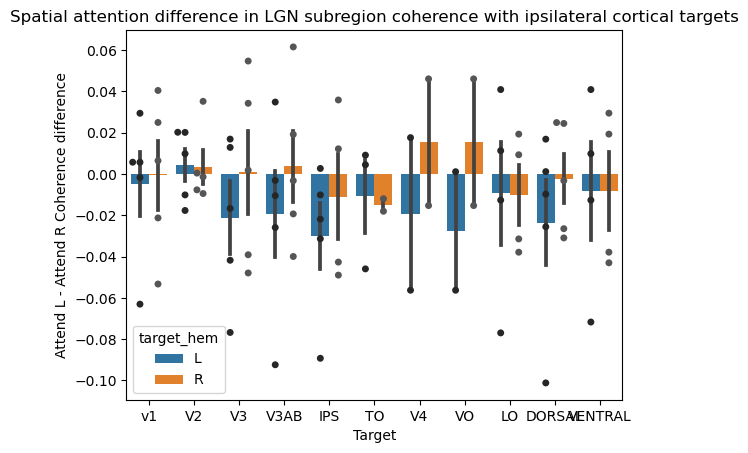

In [47]:
ax = sns.barplot(data=att_df_xmp_xseed, x='target_region', y='attlr_mean', hue="target_hem",
                errorbar="se", order=display_order)
ax.set(xlabel='Target', ylabel="Attend L - Attend R Coherence difference")
ax.title.set_text("Spatial attention difference in LGN subregion coherence with ipsilateral cortical targets")
ax = sns.swarmplot(data=att_df_xmp_xseed, x='target_region', y='attlr_mean', hue="target_hem", ax=ax, dodge=True,
                   palette='dark:#555555', legend=False)

In [48]:
att_df_xmp_xseed

,measurement,seed_hem,target_hem,subj,ipsi_seedtarget,target,target_region,attlr_mean,target_region_str
0,coherence,L,L,sub-BC,True,LDORSAL,DORSAL,-0.101176,DORSAL
1,coherence,L,L,sub-BC,True,LIPS,IPS,-0.089238,IPS
2,coherence,L,L,sub-BC,True,LLO,LO,-0.076939,LO
3,coherence,L,L,sub-BC,True,LTO,TO,-0.045935,TO
4,coherence,L,L,sub-BC,True,LV2,V2,0.020248,V2
...,...,...,...,...,...,...,...,...,...
83,coherence,R,R,sub-ZG,True,RV2,V2,-0.001360,V2
84,coherence,R,R,sub-ZG,True,RV3,V3,-0.047914,V3
85,coherence,R,R,sub-ZG,True,RV3AB,V3AB,-0.019306,V3AB
86,coherence,R,R,sub-ZG,True,RVENTRAL,VENTRAL,-0.037847,VENTRAL


In [49]:
def att_lr_diff_xhem(df):
    if (len(df)==2): # if we don't have the ROI in both hemispheres, ignore
        assert(len(df)==2)
        l = df[df.target_hem=='L']['attlr_mean']
        assert(len(l)==1)
        r = df[df.target_hem=='R']['attlr_mean']
        assert(len(r)==1)
        diff = r.iloc[0] - l.iloc[0] # R - L order gives positive quantities
        #print(diff)
        return pd.Series({'att_lr_diff_xhem': diff})
att_final_df = att_df_xmp_xseed.groupby(att_xmpseedhem_cols).apply(att_lr_diff_xhem).reset_index()
att_final_df.head()

,ipsi_seedtarget,measurement,target_region,subj,att_lr_diff_xhem
0,True,coherence,v1,sub-BC,0.041772
1,True,coherence,v1,sub-CF,0.042179
2,True,coherence,v1,sub-LL,0.019275
3,True,coherence,v1,sub-SR,-0.022985
4,True,coherence,v1,sub-ZG,-0.059015


In [50]:
att_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   ipsi_seedtarget   140 non-null    bool    
 1   measurement       140 non-null    object  
 2   target_region     140 non-null    category
 3   subj              140 non-null    object  
 4   att_lr_diff_xhem  43 non-null     float64 
dtypes: bool(1), category(1), float64(1), object(2)
memory usage: 4.9+ KB


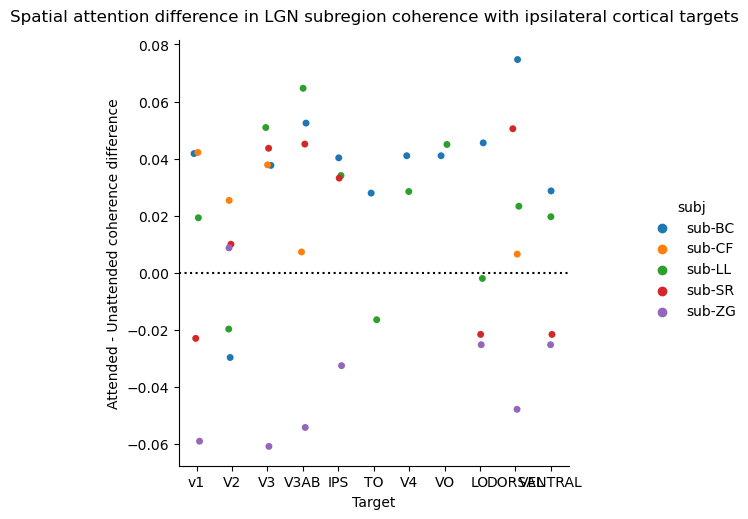

In [51]:
g = sns.catplot(data=att_final_df, kind='strip', x='target_region', y='att_lr_diff_xhem',
               sharex=False, legend=True, ci=None, order=display_order, hue='subj')
g.set_axis_labels('Target', "Attended - Unattended coherence difference") \
.fig.suptitle("Spatial attention difference in LGN subregion coherence with ipsilateral cortical targets", y=1.03)
g.ax.axhline(y=0, linestyle='dotted', color='black')

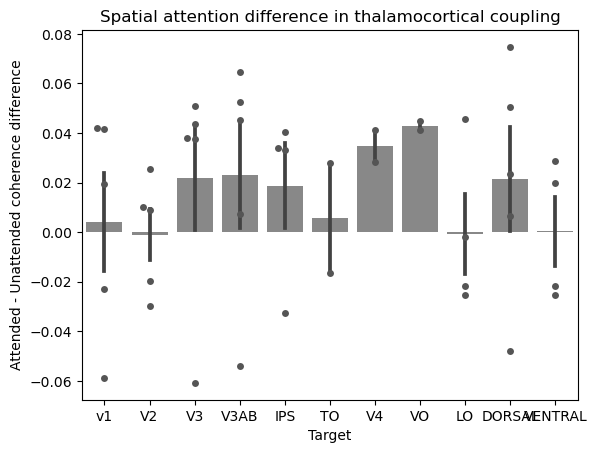

In [52]:
ax = sns.barplot(data=att_final_df, x='target_region', y='att_lr_diff_xhem', errorbar="se",
                 order=display_order, color="#888888")
ax.set(xlabel='Target', ylabel="Attended - Unattended coherence difference")
ax.title.set_text("Spatial attention difference in thalamocortical coupling")
ax = sns.swarmplot(data=att_final_df, x='target_region', y='att_lr_diff_xhem', order=display_order, color="#555555")

In [53]:
att_final_mean = att_final_df.groupby(['subj', 'measurement', 'ipsi_seedtarget']).mean().reset_index()
att_final_mean['target_region'] = 'mean'
att_plot_df = pd.concat((att_final_df, att_final_mean)).reset_index()
att_plot_df

/tmp/ipykernel_90450/3443137315.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  att_final_mean = att_final_df.groupby(['subj', 'measurement', 'ipsi_seedtarget']).mean().reset_index()


,index,ipsi_seedtarget,measurement,target_region,subj,att_lr_diff_xhem
0,0,True,coherence,v1,sub-BC,0.041772
1,1,True,coherence,v1,sub-CF,0.042179
2,2,True,coherence,v1,sub-LL,0.019275
3,3,True,coherence,v1,sub-SR,-0.022985
4,4,True,coherence,v1,sub-ZG,-0.059015
...,...,...,...,...,...,...
140,0,True,coherence,mean,sub-BC,0.036486
141,1,True,coherence,mean,sub-CF,0.023841
142,2,True,coherence,mean,sub-LL,0.022472
143,3,True,coherence,mean,sub-SR,0.014529


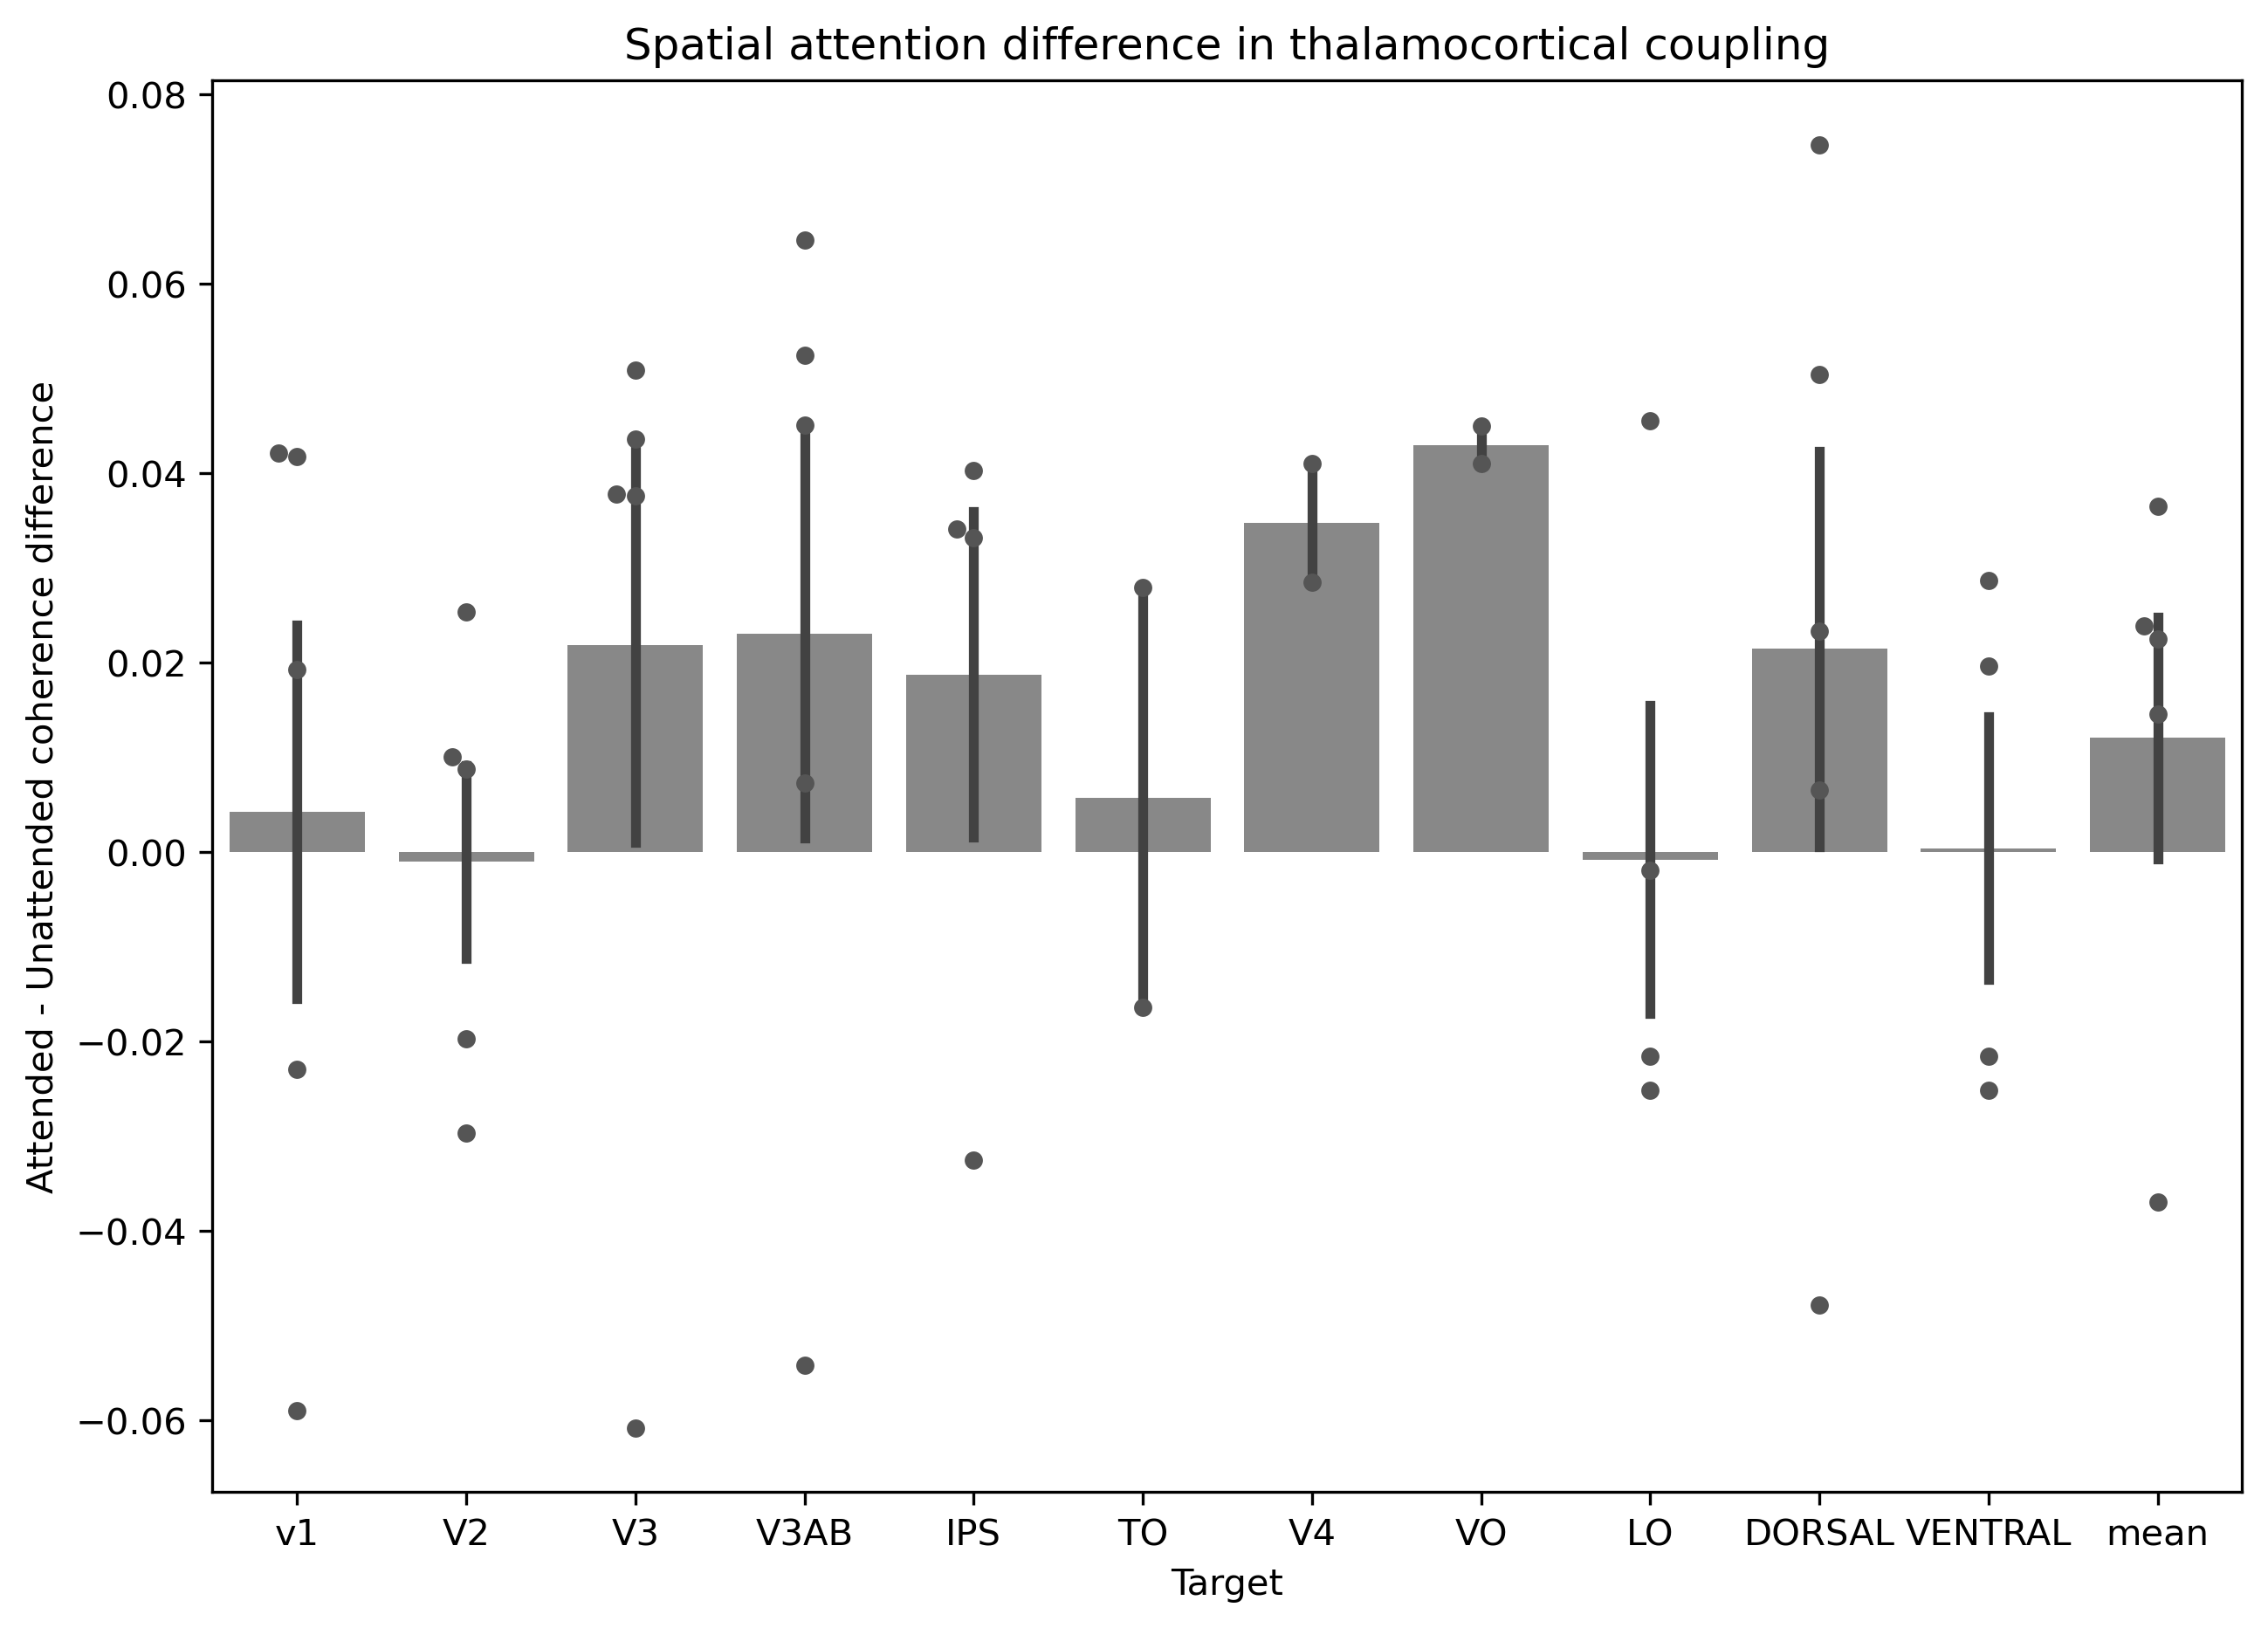

In [54]:
att_disp = display_order + ['mean']
ax = sns.barplot(data=att_plot_df, x='target_region', y='att_lr_diff_xhem', errorbar="se",
                 order=att_disp, color="#888888")
ax.figure.set_size_inches(10, 7)
ax.figure.set_dpi(300)
ax.set(xlabel='Target', ylabel="Attended - Unattended coherence difference")
ax.title.set_text("Spatial attention difference in thalamocortical coupling")
ax = sns.swarmplot(data=att_plot_df, x='target_region', y='att_lr_diff_xhem', order=att_disp, color="#555555")

In [55]:
att_final_df.dropna(inplace=True)

In [56]:
def tt(df, col='att_lr_diff_xhem'):
    print(st.ttest_1samp(df[col], popmean=0))

for gv, g in att_final_df.groupby(['target_region'], observed=True):
    print(gv, tt(g))

Ttest_1sampResult(statistic=0.21474042948441419, pvalue=0.840473430758613)
v1 None
Ttest_1sampResult(statistic=-0.10353995488821642, pvalue=0.9225179850270212)
V2 None
Ttest_1sampResult(statistic=1.049359743589884, pvalue=0.35322897742847337)
V3 None
Ttest_1sampResult(statistic=1.0697683344937754, pvalue=0.34498216760001177)
V3AB None
Ttest_1sampResult(statistic=1.0919625936131383, pvalue=0.3546959732662778)
IPS None
Ttest_1sampResult(statistic=0.2584934634165375, pvalue=0.8389629553209654)
TO None
Ttest_1sampResult(statistic=5.540881584945392, pvalue=0.11367141130917546)
V4 None
Ttest_1sampResult(statistic=21.738753769141628, pvalue=0.029264386711551064)
VO None
Ttest_1sampResult(statistic=-0.05002731770954728, pvalue=0.9632450966466501)
LO None
Ttest_1sampResult(statistic=1.0279269369881692, pvalue=0.36207800955110003)
DORSAL None
Ttest_1sampResult(statistic=0.02778816245175212, pvalue=0.9795762818706505)
VENTRAL None


/tmp/ipykernel_90450/876713941.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for gv, g in att_final_df.groupby(['target_region'], observed=True):


## Begin Phase Analysis (2023-09)

In [57]:
n_phase_bins = len(df_phase.freq_band.unique())
df_phase['freq_bin'] = df_phase.freq_band.astype('category')

In [58]:
# According to Lauritzen et al 2009, dividing the phase by the freq band center gives phase dely in units of time
# Need to then average over all relevant freq bands
df_phase['phase_delay'] = df_phase['value']/df_phase['freq_band']

In [59]:
df_phase.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35280 entries, 913 to 37239
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   subj             35280 non-null  object  
 1   seed             35280 non-null  object  
 2   target           35280 non-null  object  
 3   measurement      35280 non-null  object  
 4   freq_band        35280 non-null  float64 
 5   value            35280 non-null  float64 
 6   run              35280 non-null  object  
 7   condition        35280 non-null  object  
 8   bold             35280 non-null  object  
 9   session          35280 non-null  int64   
 10  seed_hem         35280 non-null  object  
 11  seed_region      35280 non-null  object  
 12  target_hem       35280 non-null  object  
 13  target_region    35280 non-null  category
 14  seed_mp          0 non-null      object  
 15  stim_type        35280 non-null  object  
 16  attend_hem       35280 non-null  objec

In [60]:
# avg across freq bands within one run
gv1 = ['subj','seed','seed_hem','seed_region','target','target_hem','target_region','stim_type','attend_hem','session','condition','run']
df_delays = df_phase.groupby(gv1, observed=True)['phase_delay'].agg('mean').reset_index()
# now plot run-level stats
df_delays
assert(np.all(df_delays['seed_hem']==df_delays['target_hem'])) # only looking at ipsilateral connectivity

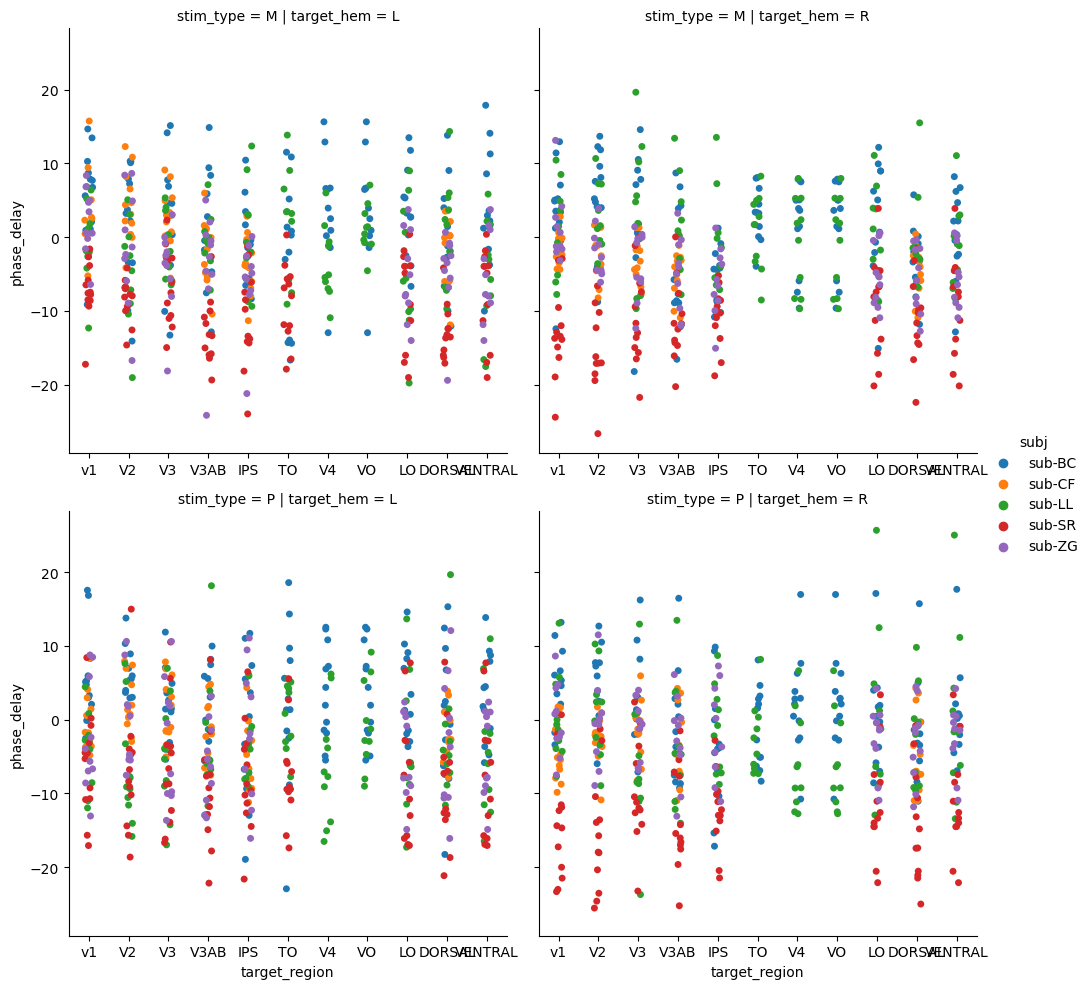

In [61]:
plot_df = df_delays.copy()
plot_df['target_region_str'] = plot_df.target_region.astype(str)
g = sns.catplot(data=plot_df, kind='strip', x='target_region', y='phase_delay', row='stim_type', col='target_hem', hue='subj',
                sharex=False, legend=True, ci=None, order=display_order)
#g.set_axis_labels('Target', "Attend L - Attend R Coherence difference") \
#        .fig.suptitle("Spatial attention difference in LGN subregion coherence with ipsilateral cortical targets", y=1.03)

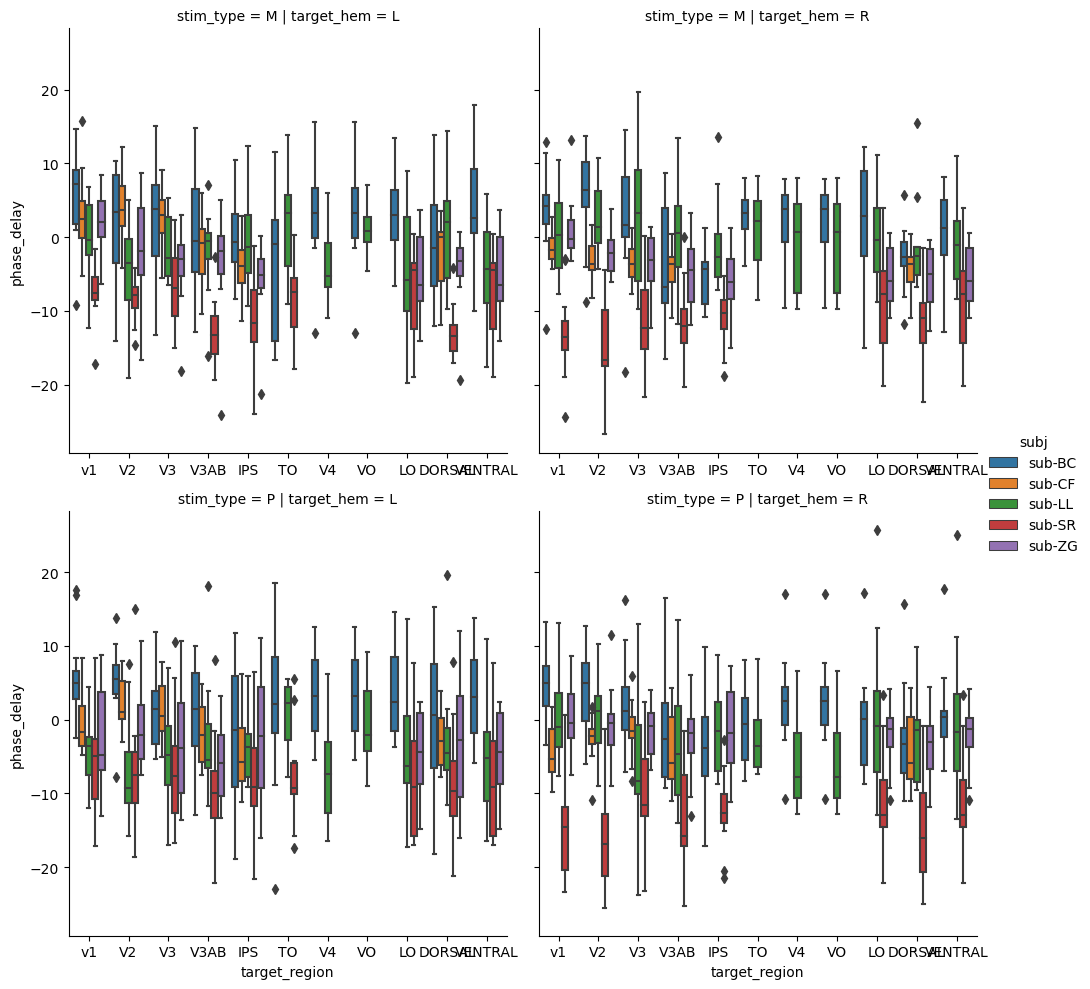

In [62]:
g = sns.catplot(data=plot_df, kind='box', x='target_region', y='phase_delay', row='stim_type', col='target_hem', hue='subj',
                sharex=False, legend=True, ci=None, order=display_order)


In [63]:
gv2 = [v for v in gv1 if v not in ['run']]
#avg across runs within condition (e.g. leftP)
df_delays = df_delays.groupby(gv2, observed=True)['phase_delay'].agg('mean').reset_index()
# now plot cond-level statistics (x multiple sessions)
df_delays

,subj,seed,seed_hem,seed_region,target,target_hem,target_region,stim_type,attend_hem,session,condition,phase_delay
0,sub-BC,LLGNrevised,L,LGNrevised,LDORSAL,L,DORSAL,M,L,1,leftM,5.520195
1,sub-BC,LLGNrevised,L,LGNrevised,LDORSAL,L,DORSAL,M,L,2,leftM,-4.576576
2,sub-BC,LLGNrevised,L,LGNrevised,LDORSAL,L,DORSAL,M,R,1,rightM,0.137641
3,sub-BC,LLGNrevised,L,LGNrevised,LDORSAL,L,DORSAL,M,R,2,rightM,-3.758158
4,sub-BC,LLGNrevised,L,LGNrevised,LDORSAL,L,DORSAL,P,L,1,leftP,8.011157
...,...,...,...,...,...,...,...,...,...,...,...,...
699,sub-ZG,RLGNrevised,R,LGNrevised,Rv1,R,v1,M,R,2,rightM,-0.592696
700,sub-ZG,RLGNrevised,R,LGNrevised,Rv1,R,v1,P,L,1,leftP,1.259844
701,sub-ZG,RLGNrevised,R,LGNrevised,Rv1,R,v1,P,L,2,leftP,3.622629
702,sub-ZG,RLGNrevised,R,LGNrevised,Rv1,R,v1,P,R,1,rightP,-0.786098


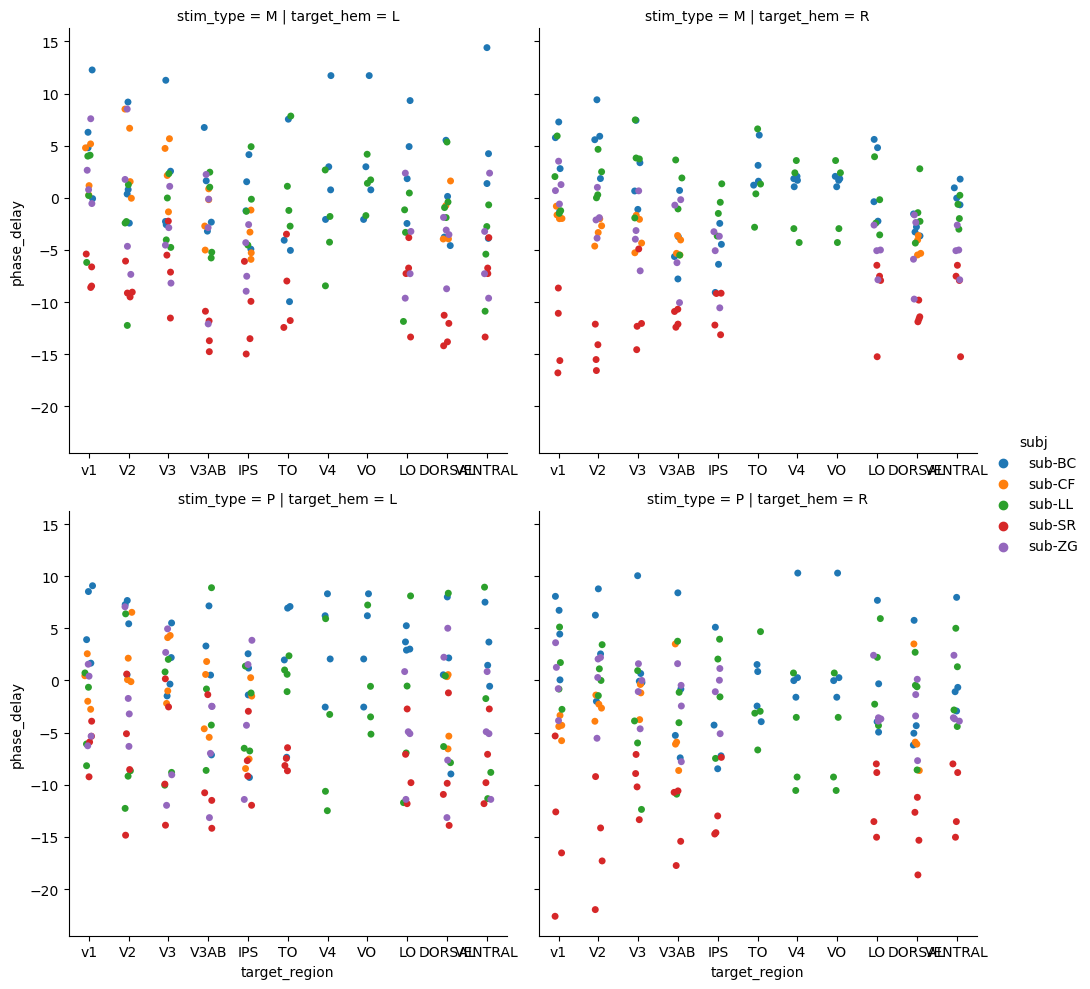

In [64]:
plot_df = df_delays.copy()
plot_df['target_region_str'] = plot_df.target_region.astype(str)
g = sns.catplot(data=plot_df, kind='strip', x='target_region', y='phase_delay', row='stim_type', col='target_hem', hue='subj',
                sharex=False, legend=True, ci=None, order=display_order)

In [65]:
gv3 = [v for v in gv2 if v not in ['session']]
# average across sessions (if not done above)
df_delays = df_delays.groupby(gv3, observed=True)['phase_delay'].agg('mean').reset_index()
# plot cond-level statistics (1 per subject)
df_delays

,subj,seed,seed_hem,seed_region,target,target_hem,target_region,stim_type,attend_hem,condition,phase_delay
0,sub-BC,LLGNrevised,L,LGNrevised,LDORSAL,L,DORSAL,M,L,leftM,0.471810
1,sub-BC,LLGNrevised,L,LGNrevised,LDORSAL,L,DORSAL,M,R,rightM,-1.810258
2,sub-BC,LLGNrevised,L,LGNrevised,LDORSAL,L,DORSAL,P,L,leftP,4.278061
3,sub-BC,LLGNrevised,L,LGNrevised,LDORSAL,L,DORSAL,P,R,rightP,-3.399609
4,sub-BC,LLGNrevised,L,LGNrevised,LIPS,L,IPS,M,L,leftM,1.450439
...,...,...,...,...,...,...,...,...,...,...,...
347,sub-ZG,RLGNrevised,R,LGNrevised,RVENTRAL,R,VENTRAL,P,R,rightP,-3.733805
348,sub-ZG,RLGNrevised,R,LGNrevised,Rv1,R,v1,M,L,leftM,2.103540
349,sub-ZG,RLGNrevised,R,LGNrevised,Rv1,R,v1,M,R,rightM,0.338304
350,sub-ZG,RLGNrevised,R,LGNrevised,Rv1,R,v1,P,L,leftP,2.441237


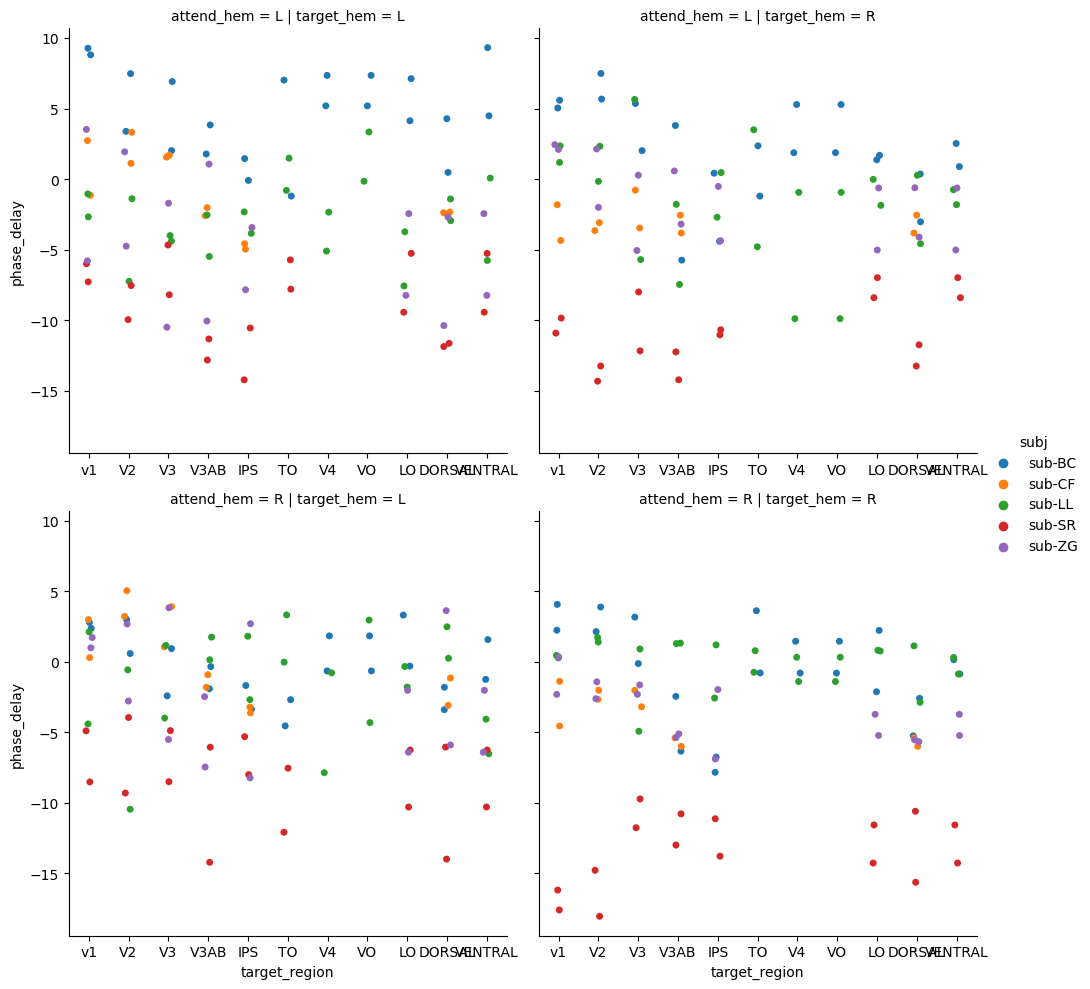

In [66]:
plot_df = df_delays.copy()
plot_df['target_region_str'] = plot_df.target_region.astype(str)
g = sns.catplot(data=plot_df, kind='strip', x='target_region', y='phase_delay', row='attend_hem', col='target_hem', hue='subj',
                sharex=False, legend=True, ci=None, order=display_order)